# Setup

In [ ]:
pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.2/285.2 kB 4.7 MB/s eta 0:00:00


#Calls to NBA API

In [ ]:
# prompt: call to the nba api for play by play data by team, for all games in a season

from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams
import pandas as pd

# Find all games for a specific team in a season
def get_games_by_team_season(team_id, season):
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id, season_nullable=season)
    games = gamefinder.get_data_frames()[0]
    return games

# Example usage:
team_name = "Golden State Warriors" #Change team name here
team = [team for team in teams.get_teams() if team['full_name'] == team_name][0]
team_id = team['id']
season = "2023-24"  # Change the season year as needed

games = get_games_by_team_season(team_id, season)
print(f"Games for {team_name} in {season}:")
games.to_csv('games.csv', index=False)
print(games)


Games for Golden State Warriors in 2023-24:
   SEASON_ID     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME     GAME_ID  \
0      52023  1610612744               GSW  Golden State Warriors  0052300131   
1      22023  1610612744               GSW  Golden State Warriors  0022301198   
2      22023  1610612744               GSW  Golden State Warriors  0022301182   
3      22023  1610612744               GSW  Golden State Warriors  0022301169   
4      22023  1610612744               GSW  Golden State Warriors  0022301155   
..       ...         ...               ...                    ...         ...   
83     12023  1610612744               GSW  Golden State Warriors  0012300073   
84     12023  1610612744               GSW  Golden State Warriors  0012300059   
85     12023  1610612744               GSW  Golden State Warriors  0012300043   
86     12023  1610612744               GSW  Golden State Warriors  0012300034   
87     12023  1610612744               GSW  Golden State Warriors

In [ ]:
import time
import random
import pandas as pd
from nba_api.stats.endpoints import playbyplay, leaguegamefinder, boxscoresummaryv2, commonteamroster

# Get all game data for a given season
games = leaguegamefinder.LeagueGameFinder(season_nullable="2023-24").get_data_frames()[0]

# Extract unique game IDs
game_ids = games['GAME_ID'].unique().tolist()

all_plays = []
failed_games = []

for game_id in game_ids[:100]:  # Fetch first 10 games as a test
    try:
        print(f"Fetching data for game {game_id}...")

        # Fetch play-by-play data
        df = playbyplay.PlayByPlay(game_id).get_data_frames()[0]

        # Get game summary to extract team info
        game_summary = boxscoresummaryv2.BoxScoreSummaryV2(game_id).get_data_frames()[0]
        home_team_id = game_summary.loc[0, 'HOME_TEAM_ID']
        away_team_id = game_summary.loc[0, 'VISITOR_TEAM_ID']

        # Fetch team names by mapping team IDs from `games` dataframe
        home_team_name = games.loc[games['TEAM_ID'] == home_team_id, 'TEAM_NAME'].values[0]
        away_team_name = games.loc[games['TEAM_ID'] == away_team_id, 'TEAM_NAME'].values[0]

        # Add metadata
        df['GAME_ID'] = game_id
        df['HOME_TEAM_ID'] = home_team_id
        df['AWAY_TEAM_ID'] = away_team_id
        df['HOME_TEAM_NAME'] = home_team_name
        df['AWAY_TEAM_NAME'] = away_team_name

        all_plays.append(df)
        time.sleep(2 + random.uniform(0, 1))  # Delay to avoid rate limits

    except Exception as e:
        print(f"Failed to fetch game {game_id}: {e}")
        failed_games.append(game_id)

# Combine all games into a single DataFrame
play_by_play_data = pd.concat(all_plays, ignore_index=True)

# Save to CSV for bulk analysis
play_by_play_data.to_csv("nba_play_by_play1.csv", index=False)

print("Data collection complete. Failed games:", failed_games)


KeyboardInterrupt: 

In [ ]:
import time
from nba_api.stats.endpoints import playbyplay
from nba_api.stats.endpoints import leaguegamefinder

# Get all game data for a given season
games = leaguegamefinder.LeagueGameFinder(season_nullable="2023-24").get_data_frames()[0]

# Extract unique game IDs
game_ids = games['GAME_ID'].unique().tolist()
game_info = games[['GAME_ID', 'TEAM_ID', 'MATCHUP']].drop_duplicates()



all_plays = []
failed_games = []

for game_id in game_ids[:10]:  # Fetch first 10 games as a test
    try:
        print(f"Fetching data for game {game_id}...")
        df = playbyplay.PlayByPlay(game_id).get_data_frames()[0]
        df['GAME_ID'] = game_id  # Tag with game ID
        df["matchup"] = game_info.loc[game_info['GAME_ID'] == game_id, 'MATCHUP'].iloc[0] # tags with matchup
        all_plays.append(df)
        time.sleep(2)  # Add a delay to avoid rate limits
    except Exception as e:
        print(f"Failed to fetch game {game_id}: {e}")
        failed_games.append(game_id)

# Combine all games into a single DataFrame
import pandas as pd
play_by_play_data = pd.concat(all_plays, ignore_index=True)

# Save to CSV for bulk analysis
play_by_play_data.to_csv("nba_play_by_play.csv", index=False)


Fetching data for game 0042300405...
Fetching data for game 0042300404...
Fetching data for game 0042300403...
Fetching data for game 0042300402...
Fetching data for game 0042300401...
Fetching data for game 0042300315...
Fetching data for game 0042300314...
Fetching data for game 0042300304...
Fetching data for game 0042300313...
Fetching data for game 0042300303...


In [ ]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import Season
from nba_api.stats.library.parameters import SeasonType
from nba_api.stats.endpoints import playbyplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ... (Your existing code for data cleaning, plotting, etc.) ...

# Iterate through Pacers games

import time
import requests
from nba_api.stats.endpoints import playbyplay

game_ids = ["0022401229", "0022401202", "0022400103"]  # Example game IDs
all_plays = []

for game_id in game_ids:
    max_retries = 5  # Retry up to 5 times
    for attempt in range(max_retries):
        try:
            print(f"Fetching game {game_id}, attempt {attempt + 1}")
            response = requests.get(
                f"https://stats.nba.com/stats/playbyplayv2?GameID={game_id}",
                headers={"User-Agent": "Mozilla/5.0"},
                timeout=10,
            )

            if response.status_code == 403:
                print(f"Rate limited (403) for game {game_id}. Try slowing down requests.")
                time.sleep(60)  # Wait 1 minute before retrying
            elif response.status_code == 429:
                print(f"Too many requests (429) for game {game_id}. Waiting before retrying...")
                time.sleep(120)  # Wait 2 minutes before retrying
            elif response.status_code == 200:
                df = playbyplay.PlayByPlay(game_id).get_data_frames()[0]
                all_plays.append(df)
                break  # Success, exit retry loop
            else:
                print(f"Unexpected error {response.status_code} for game {game_id}")
                break  # Stop retrying on unknown errors

        except requests.exceptions.RequestException as e:
            print(f"Error fetching game {game_id}: {e}")
            time.sleep(5)  # Short delay before retrying
all_plays.append(response)
all_plays = pd.concat(all_plays, ignore_index=True)
all_plays.to_csv('nba_play_by_play.csv', index=False)


# all_plays = []

# nba_teams = teams.get_teams()
# for team in nba_teams[:3]:
#   team_name = team['abbreviation']
#   id = team['id']

#   gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=id,
#                               season_nullable=Season.default,
#                               season_type_nullable=SeasonType.regular)

#   games_dict = gamefinder.get_normalized_dict()
#   games = games_dict['LeagueGameFinderResults']

#   for game in games:
#       game_id = game['GAME_ID']
#       # print(f"Processing game: {game_id}")

#       try:
#           # Get play-by-play data
#           df = playbyplay.PlayByPlay(game_id).get_data_frames()[0]

#           all_plays.append(df)


#       except Exception as e:
#           print(f"Error processing game {game_id}: {e}")

# if all_plays:
#     combined_plays = pd.concat(all_plays, ignore_index=True)
#     combined_plays.to_csv('nba_play_by_play.csv', index=False)
#     # print("Play-by-play data saved to nba_play_by_play.csv")


Fetching game 0022401229, attempt 1
Error fetching game 0022401229: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=10)
Fetching game 0022401229, attempt 2
Error fetching game 0022401229: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=10)
Fetching game 0022401229, attempt 3
Error fetching game 0022401229: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=10)
Fetching game 0022401229, attempt 4
Error fetching game 0022401229: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=10)
Fetching game 0022401229, attempt 5
Error fetching game 0022401229: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=10)
Fetching game 0022401202, attempt 1
Error fetching game 0022401202: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=10)
Fetching game 0022401202, attempt 2
Error fetching game 0022401202: HT

NameError: name 'response' is not defined

In [ ]:
from nba_api.stats.static import teams

# get_teams returns a list of 30 dictionaries, each an NBA team.
nba_teams = teams.get_teams()
print("Number of teams fetched: {}".format(len(nba_teams)))
nba_teams[:3]

Number of teams fetched: 30


[{'id': 1610612737,
  'full_name': 'Atlanta Hawks',
  'abbreviation': 'ATL',
  'nickname': 'Hawks',
  'city': 'Atlanta',
  'state': 'Georgia',
  'year_founded': 1949},
 {'id': 1610612738,
  'full_name': 'Boston Celtics',
  'abbreviation': 'BOS',
  'nickname': 'Celtics',
  'city': 'Boston',
  'state': 'Massachusetts',
  'year_founded': 1946},
 {'id': 1610612739,
  'full_name': 'Cleveland Cavaliers',
  'abbreviation': 'CLE',
  'nickname': 'Cavaliers',
  'city': 'Cleveland',
  'state': 'Ohio',
  'year_founded': 1970}]

Get All Celtics Games

In [ ]:

from nba_api.stats.static import teams

nba_teams = teams.get_teams()
# Select the dictionary for the Celtics, which contains their team ID
celtics = [team for team in nba_teams if team['abbreviation'] == 'BOS'][0]
celtics_id = celtics['id']

In [ ]:
from nba_api.stats.endpoints import leaguegamefinder

# Query for games where the Celtics were playing
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=celtics_id)
# The first DataFrame of those returned is what we want.
games = gamefinder.get_data_frames()[0]
games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22024,1610612738,BOS,Boston Celtics,0022400650,2025-01-27,BOS vs. HOU,L,239,112,...,0.950,7,34,41,21,4,4,14,20,-2.0
1,22024,1610612738,BOS,Boston Celtics,0022400635,2025-01-25,BOS @ DAL,W,241,122,...,0.737,17,34,51,33,4,5,5,24,15.0
2,22024,1610612738,BOS,Boston Celtics,0022400629,2025-01-23,BOS @ LAL,L,239,96,...,0.667,11,31,42,23,5,6,7,17,-21.0
3,22024,1610612738,BOS,Boston Celtics,0022400620,2025-01-22,BOS @ LAC,W,265,117,...,0.800,8,24,32,24,11,4,19,14,4.0
4,22024,1610612738,BOS,Boston Celtics,0022400604,2025-01-20,BOS @ GSW,W,239,125,...,0.875,8,42,50,33,8,9,9,8,40.0


In [ ]:
#Get the Pacers team_id
from nba_api.stats.static import teams

nba_teams = teams.get_teams()

# Select the dictionary for the Pacers, which contains their team ID
pacers = [team for team in nba_teams if team['abbreviation'] == 'IND'][0]
pacers_id = pacers['id']
print(f'pacers_id: {pacers_id}')

pacers_id: 1610612754


In [ ]:
# Query for the last regular season game where the Pacers were playing
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import Season
from nba_api.stats.library.parameters import SeasonType

gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=pacers_id,
                            season_nullable=Season.default,
                            season_type_nullable=SeasonType.regular)

games_dict = gamefinder.get_normalized_dict()
games = games_dict['LeagueGameFinderResults']
game = games[1]
game_id = game['GAME_ID']
game_matchup = game['MATCHUP']

print(f'Searching through {len(games)} game(s) for the game_id of {game_id} where {game_matchup}')

Searching through 45 game(s) for the game_id of 0022400621 where SAS @ IND


In [ ]:
# Query for the play by play of that most recent regular season game
from nba_api.stats.endpoints import playbyplay
df = playbyplay.PlayByPlay(game_id).get_data_frames()[0]
df.head() #just looking at the head of the data

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN
0,0022400621,2,12,0,1,2:16 PM,12:00,None,Start of 1st Period (2:16 PM EST),None,None,None
1,0022400621,4,10,0,1,2:16 PM,12:00,Jump Ball Turner vs. Wembanyama: Tip to Barnes,None,None,None,None
2,0022400621,7,2,71,1,2:17 PM,11:44,None,None,MISS Wembanyama 6' Finger Roll Layup,None,None
3,0022400621,8,4,0,1,2:17 PM,11:42,Turner REBOUND (Off:0 Def:1),None,None,None,None
4,0022400621,9,1,75,1,2:17 PM,11:30,Siakam 5' Driving Finger Roll Layup (2 PTS),None,None,0 - 2,2


# DATA Entry and Cleaning

In [ ]:
import pandas as pd

try:
  df = pd.read_csv('2019-20_pbp_ready.csv')
except FileNotFoundError:
  print("One or more CSV files not found. Please check file names and paths.")
except Exception as e:
  print(f"An error occurred: {e}")


In [ ]:
df.head()

,URL,GameType,Location,Date,Time,WinningTeam,Quarter,SecLeft,AwayTeam,AwayPlay,...,JumpballPoss,Unnamed: 40,SCOREMARGIN,HOMETIMEOUT,AWAYTIMEOUT,time_in_seconds,time_normalized,Matchup,EVENTMSGTYPE,HOMEDESCRIPTION
0,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,720,NOP,Jump ball: D. Favors vs. M. Gasol (L. Ball gai...,...,L. Ball - balllo01,NaN,0,0,0,0,0.000000,NOP @ TOR,0,NaN
1,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,708,NOP,L. Ball misses 2-pt jump shot from 11 ft,...,NaN,NaN,0,0,0,12,0.004167,NOP @ TOR,0,NaN
2,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,707,NOP,Offensive rebound by D. Favors,...,NaN,NaN,0,0,0,13,0.004514,NOP @ TOR,0,NaN
3,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,707,NOP,D. Favors makes 2-pt layup at rim,...,NaN,NaN,-2,0,0,13,0.004514,NOP @ TOR,1,NaN
4,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,689,NOP,NaN,...,NaN,NaN,-2,0,0,31,0.010764,NOP @ TOR,0,NaN


In [ ]:
import pandas as pd

try:
  df1 = pd.read_csv('nba_play_by_play1.csv')
  df2 = pd.read_csv('nba_play_by_play.csv')
  df3 = pd.read_csv('nba_play_by_play2.csv')
  df4 = pd.read_csv('nba_play_by_play3.csv')
  df5 = pd.read_csv('nba_play_by_play4.csv')
  df6 = pd.read_csv('nba_play_by_play5.csv')

  # Concatenate all dataframes
  df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

  print("Combined DataFrame created successfully.")

except FileNotFoundError:
  print("One or more CSV files not found. Please check file names and paths.")
except Exception as e:
  print(f"An error occurred: {e}")

# df = time_df(df)
df = clean_df(df)
df.head()




Combined DataFrame created successfully.


,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,HOME_TEAM_ID,AWAY_TEAM_ID,HOME_TEAM_NAME,AWAY_TEAM_NAME,SCOREMARGIN2,HOMETIMEOUT,AWAYTIMEOUT
0,42300405,2,12,0,1,8:39 PM,12:00,,Start of 1st Period (8:39 PM EST),NaN,NaN,NaN,1610612738,1610612742,Boston Celtics,Dallas Mavericks,0,False,False
1,42300405,4,10,0,1,8:39 PM,12:00,Jump Ball Horford vs. Gafford: Tip to Brown,NaN,NaN,NaN,NaN,1610612738,1610612742,Boston Celtics,Dallas Mavericks,0,False,False
2,42300405,7,1,6,1,8:39 PM,11:40,Holiday 1' Driving Layup (2 PTS) (Tatum 1 AST),NaN,NaN,0 - 2,2,1610612738,1610612742,Boston Celtics,Dallas Mavericks,-2,False,False
3,42300405,9,2,80,1,8:39 PM,11:23,,NaN,MISS Doncic 27' 3PT Step Back Jump Shot,NaN,NaN,1610612738,1610612742,Boston Celtics,Dallas Mavericks,0,False,False
4,42300405,10,4,0,1,8:40 PM,11:22,Tatum REBOUND (Off:0 Def:1),NaN,NaN,NaN,NaN,1610612738,1610612742,Boston Celtics,Dallas Mavericks,0,False,False


DATA CLEANING

In [ ]:
# Used for data from API
import pandas as pd

def split_time_string(time_string):
    """Splits time sring into minutes and seconds

    Args:
      time_string: minutes second time stored as mm:ss

    Returns:
      minutes: int
      seconds: int
    """
    minutes, seconds = time_string.split(':')
    return int(minutes), int(seconds)

def split_score_string(score_string):
    """Splits time sring into minutes and seconds

    Args:
      time_string: minutes second time stored as mm:ss

    Returns:
      minutes: int
      seconds: int
    """
    if pd.isna(score_string):
      home_score = 0
      away_score = 0
    else:
      home_score, away_score = score_string.split('-')
      home_score = int(home_score)
      away_score = int(away_score)
    score_margin = home_score - away_score
    return score_margin

def scoremargin_df(df):
  df['SCOREMARGIN2'] = df['SCORE'].apply(lambda x: pd.Series(split_score_string(x)))
  return df


def calculate_seconds(quarter, minute, seconds):
  """Calculates a time value based on the given parameters.

  Args:
    quarter: The quarter number.
    minute: The minute number.
    seconds: The seconds number.

  Returns:
     The calculated time value.
  """
  return ((quarter - 1) * 720) + ((12 - minute) * 60) - 60  +  60 - seconds

def time_df(df):
  df[['minutes', 'seconds']] = df['PCTIMESTRING'].apply(lambda x: pd.Series(split_time_string(x)))
  df['time_in_seconds'] = df.apply(lambda row: calculate_seconds(row['PERIOD'], row['minutes'], row['seconds']), axis=1)
  df['time_normalized'] = df['time_in_seconds'] / (4*12*60) #quarters * minutes * seconds, scales to 0-1 with overtime > 1
  return df

def clean_df(df):

  # Apply the functions to create new columns
  df = scoremargin_df(df)
  # df['TRUESCOREMARGIN'] = df['TRUESCOREMARGIN'].fillna(0)
  # df['TRUESCOREMARGIN'] = df['TRUESCOREMARGIN'].replace('TIE', 0)
  df['HOMEDESCRIPTION'] = df['HOMEDESCRIPTION'].fillna("")
  df['HOMETIMEOUT'] = df['HOMEDESCRIPTION'].str.contains('Timeout')
  df['AWAYTIMEOUT'] = df['VISITORDESCRIPTION'].str.contains('Timeout')
  df['HOMETIMEOUT'] = df['HOMETIMEOUT'].fillna(0).astype(bool)
  df['AWAYTIMEOUT'] = df['AWAYTIMEOUT'].fillna(0).astype(bool)

  return df

# df = clean_df(df)


# Print or further process the updated DataFrame
# print(df.head())

In [ ]:
# prompt: I want a function to determine the timeout team, the column TimeoutTeam holds the abbreviation of the team that called the timeout, while the columns hometeam and awayteam hold the abbreviation of the respective team. I want two return columns with binary values for when the timeout was called.

def timeout_teams(df):
    """
    Identifies the team that called a timeout and creates binary columns.

    Args:
      df: DataFrame containing game play-by-play data.  Must include columns
        'TimeoutTeam', 'HomeTeam', and 'AwayTeam'.

    Returns:
      DataFrame with added 'HomeTimeout' and 'AwayTimeout' binary columns.
    """
    df['HOMETIMEOUT'] = 0
    df['AWAYTIMEOUT'] = 0

    # Check for timeout and assign binary values based on the TimeoutTeam
    for index, row in df.iterrows():
        if row['TimeoutTeam'] == row['HomeTeam']:
            df.loc[index, 'HOMETIMEOUT'] = 1
        elif row['TimeoutTeam'] == row['AwayTeam']:
            df.loc[index, 'AWAYTIMEOUT'] = 1

    return df


In [ ]:
# used for data from sports statistics
import pandas as pd


def scoremargin_df(df):
  df['SCOREMARGIN'] = df['HomeScore'] - df['AwayScore']
  return df

def calculate_seconds(quarter, seconds):
  """Calculates a time value based on the given parameters.

  Args:
    quarter: The quarter number.
    seconds: The seconds left in a quarter

  Returns:
     The calculated time value.
  """
  return ((quarter - 1) * 720) + 720 - seconds

def time_df(df):
  df['time_in_seconds'] = df.apply(lambda row: calculate_seconds(row['Quarter'], row['SecLeft']), axis=1)
  df['time_normalized'] = df['time_in_seconds'] / (4*12*60) #quarters * minutes * seconds, scales to 0-1 with overtime > 1
  return df

def add_eventmsgtype(df):
    df['EVENTMSGTYPE'] = 0  # Initialize the column with zeros
    df['HOMEDESCRIPTION'] = "" #Initialize blank

    # Iterate through the DataFrame, comparing current and previous scores
    for i in range(1, len(df)):
        if df['HomeScore'].iloc[i] > df['HomeScore'].iloc[i-1]:
            df.loc[i, 'EVENTMSGTYPE'] = 1  # Home team scored
            df.loc[i, 'HOMEDESCRIPTION'] = "Home team scored"
        elif df['AwayScore'].iloc[i] > df['AwayScore'].iloc[i-1]:
            df.loc[i, 'EVENTMSGTYPE'] = 1  # Away team scored
    return df


def clean_df(df):

  # Apply the functions to create new columns
  df = scoremargin_df(df)
  df = timeout_teams(df)
  df = time_df(df)
  df["Matchup"] = df["AwayTeam"] + " @ " + df["HomeTeam"]
  return df

df = clean_df(df)


# Print or further process the updated DataFrame
# print(df.head())

In [ ]:
df.to_csv('2019-20_pbp_cleaned.csv', index=False)

In [ ]:
# prompt: clear df

import pandas as pd

def clear_df(df):
  """Clears the DataFrame by dropping all rows and resetting the index.

  Args:
    df: The pandas DataFrame to clear.

  Returns:
    A new empty DataFrame with the same columns as the original.
  """

  # Drop all rows
  df = df.iloc[0:0]

  # Reset the index
  df = df.reset_index(drop=True)

  return df

# Example usage (assuming 'df' is your DataFrame)
df = clear_df(df)
# print(df)


In [ ]:
import pandas as pd
df = pd.read_csv('2019-20_pbp_ready.csv')

In [ ]:
df.head()

,URL,GameType,Location,Date,Time,WinningTeam,Quarter,SecLeft,AwayTeam,AwayPlay,...,JumpballPoss,Unnamed: 40,SCOREMARGIN,HOMETIMEOUT,AWAYTIMEOUT,time_in_seconds,time_normalized,Matchup,EVENTMSGTYPE,HOMEDESCRIPTION
0,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,720,NOP,Jump ball: D. Favors vs. M. Gasol (L. Ball gai...,...,L. Ball - balllo01,NaN,0,0,0,0,0.000000,NOP @ TOR,0,NaN
1,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,708,NOP,L. Ball misses 2-pt jump shot from 11 ft,...,NaN,NaN,0,0,0,12,0.004167,NOP @ TOR,0,NaN
2,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,707,NOP,Offensive rebound by D. Favors,...,NaN,NaN,0,0,0,13,0.004514,NOP @ TOR,0,NaN
3,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,707,NOP,D. Favors makes 2-pt layup at rim,...,NaN,NaN,-2,0,0,13,0.004514,NOP @ TOR,1,NaN
4,/boxscores/201910220TOR.html,regular,Scotiabank Arena Toronto Canada,October 22 2019,8:00 PM,TOR,1,689,NOP,NaN,...,NaN,NaN,-2,0,0,31,0.010764,NOP @ TOR,0,NaN


# Exploratory Charts

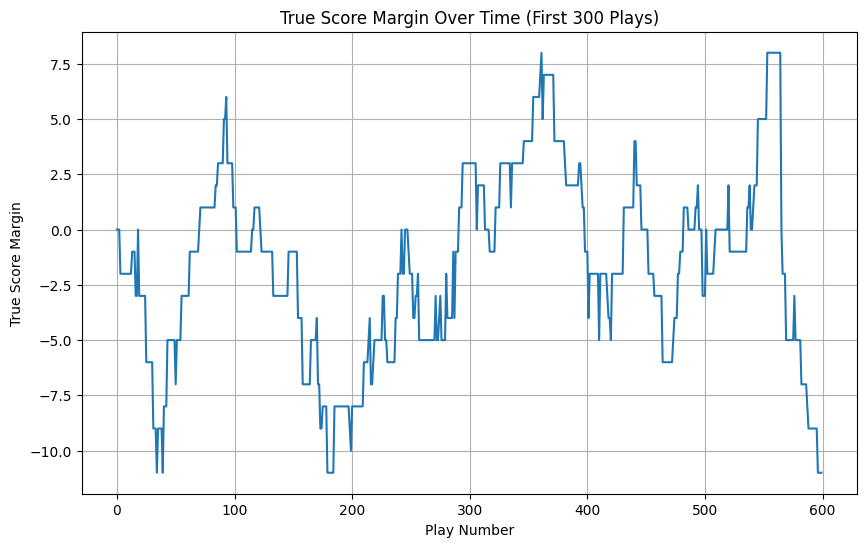

In [ ]:


import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'TRUESCOREMARGIN' is the column you want to plot
try:
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  plt.plot(df['SCOREMARGIN'][:300])  # Plot the first 300 values
  plt.xlabel("Play Number")  # Assuming the x axis represents the play number
  plt.ylabel("True Score Margin")
  plt.title("True Score Margin Over Time (First 300 Plays)")
  plt.grid(True)
  plt.show()
except Exception as e:
  print(f"An error occurred during plotting: {e}")


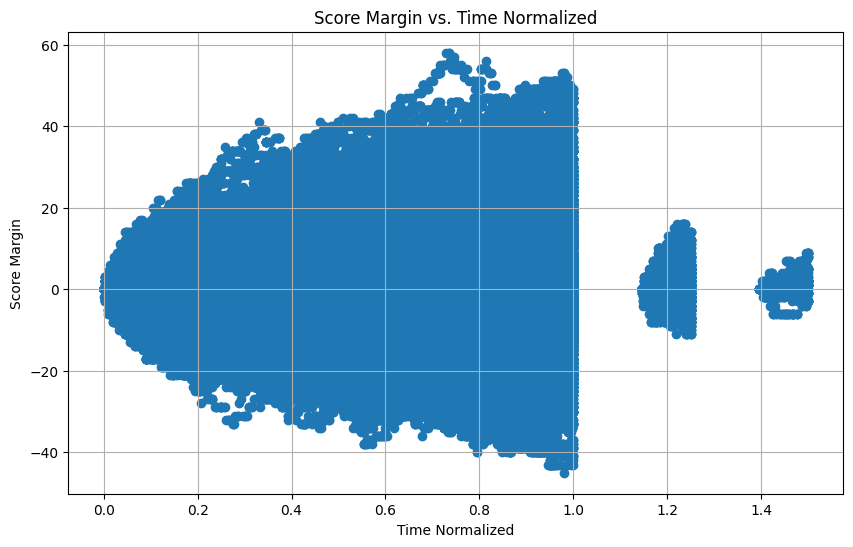

In [ ]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['time_normalized'], df['SCOREMARGIN'])
plt.xlabel('Time Normalized')
plt.ylabel('Score Margin')
plt.title('Score Margin vs. Time Normalized')
plt.grid(True)
plt.show()

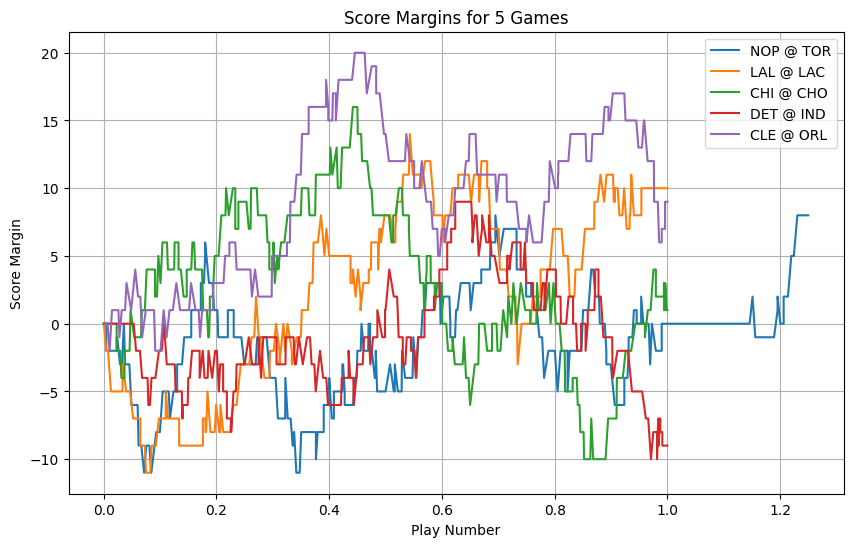

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_score_margins(df, num_games=5):
    """
    Plots score margins for a specified number of games on the same axis.

    Args:
        df: DataFrame containing game data with 'URL', 'SCOREMARGIN', and potentially other columns.
        num_games: Number of games to plot.
    """
    plt.figure(figsize=(10, 6))
    labels = []
    unique_urls = df['URL'].unique()  # Assuming 'URL' is your unique identifier
    for url in unique_urls[:num_games]:  # Iterate through the specified number of unique URLs
      game_df = df[df['URL'] == url] # Subset df by game url
      labels = (game_df['Matchup'].iloc[0])
      if not game_df.empty:
          plt.plot(game_df['time_normalized'], game_df['SCOREMARGIN'], label=labels) # Plot score margin for the game

    plt.xlabel("Play Number")
    plt.ylabel("Score Margin")
    plt.title(f"Score Margins for {num_games} Games")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage (assuming your DataFrame is named 'df'):
# Replace 'your_dataframe.csv' with the actual path to your CSV file.
try:
  # Assuming 'URL' column exists, if not replace with your identifier column
  if 'URL' not in df.columns:
    print("Error: 'URL' column not found in the DataFrame. Please replace 'URL' with your identifier column name in the code.")

  else:
    plot_score_margins(df)
except FileNotFoundError:
    print("Error: 'nba_play_by_play.csv' not found. Please make sure the file exists in the current directory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


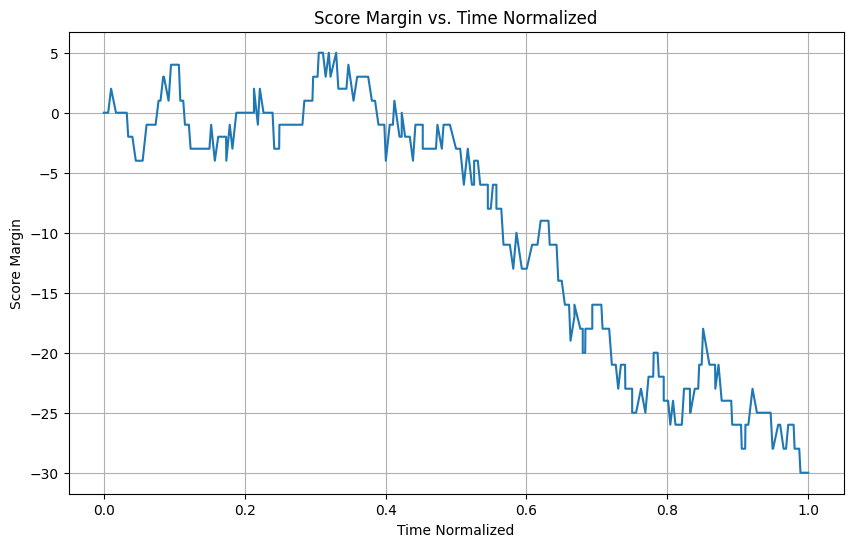

In [ ]:
import matplotlib.pyplot as plt

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(df['time_normalized'], df['TRUESCOREMARGIN'])
plt.xlabel('Time Normalized')
plt.ylabel('Score Margin')
plt.title('Score Margin vs. Time Normalized')
plt.grid(True)
plt.show()

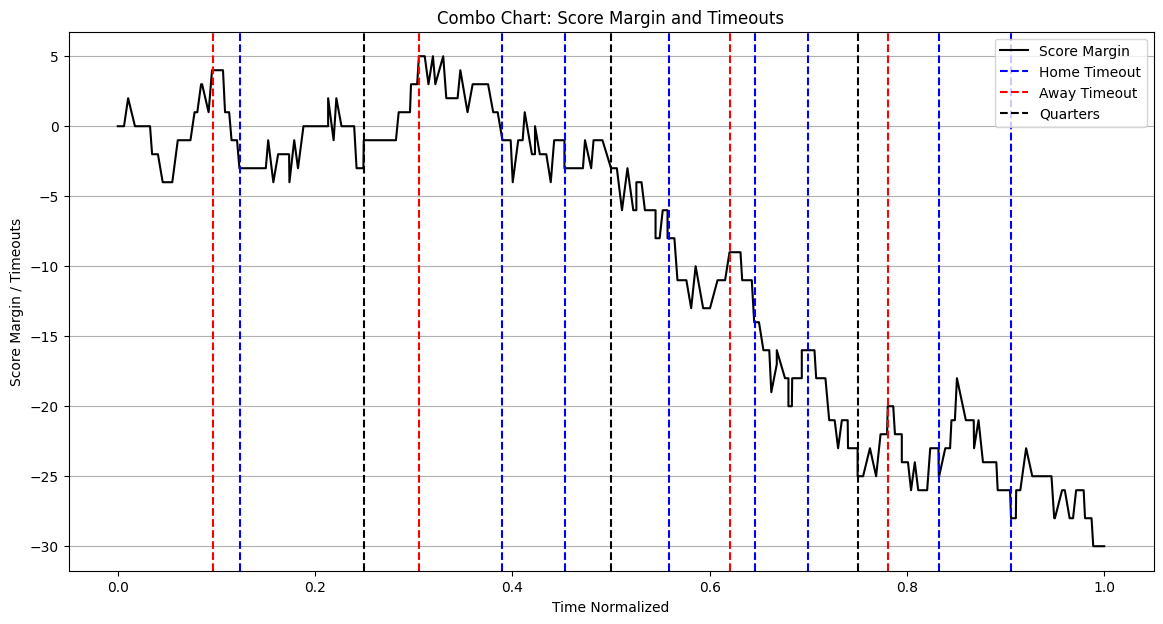

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))



# Line chart for score margin
plt.plot(df['time_normalized'], df['TRUESCOREMARGIN'], label='Score Margin', color='black')


# Column chart for timeouts
timeout_indices_home = df.index[df['HOMETIMEOUT'] == 1]
timeout_indices_away = df.index[df['AWAYTIMEOUT'] == 1]


first = True
for t in timeout_indices_home:
  if first:
    first = False
    plt.axvline(x=df['time_normalized'][t], color='blue', linestyle='--', label='Home Timeout')
  else:
    plt.axvline(x=df['time_normalized'][t], color='blue', linestyle='--')

first = True
for t in timeout_indices_away:
  if first:
    first = False
    plt.axvline(x=df['time_normalized'][t], color='Red', linestyle='--', label='Away Timeout')
  else:
    plt.axvline(x=df['time_normalized'][t], color='Red', linestyle='--')

quarter_timeouts = [.25,.5,.75]
first = True
for t in quarter_timeouts:
  if first:
    first = False
    plt.axvline(x=t, color='black', linestyle='--', label='Quarters')
  else:
    plt.axvline(x=t, color='black', linestyle='--')

# plt.bar(df['time_normalized'][timeout_indices_home], [1] * len(timeout_indices_home), width=0.01, color='red', label='Home Timeout')
# plt.bar(df['time_normalized'][timeout_indices_away], [1] * len(timeout_indices_away), width=0.01, color='blue', label='Away Timeout')

# Customize the plot
plt.xlabel('Time Normalized')
plt.ylabel('Score Margin / Timeouts')
plt.title('Combo Chart: Score Margin and Timeouts')
plt.grid(True, axis='y')
plt.legend()
plt.show()

#TODO - Exponential decay using Convolution kernel

In [ ]:
#TODO:

def lens(df, width, thresh):
  """
  Increments through the data one row at a time, comparing the score margin
  at the front of the lens to the score margin at the back of the lens.

  Args:
    df: The DataFrame containing the game data.
    width: The width of the lens (number of rows).

  Returns:
    A list of score margin differences.
  """
  differences = []
  for i in range(len(df) - width):
    front_margin = df['TRUESCOREMARGIN'].iloc[i+1]
    back_margin = df['TRUESCOREMARGIN'].iloc[i + width]

    # Convert to numeric, handling potential errors
    try:
        front_margin = int(front_margin)
        back_margin = int(back_margin)
        # differences.append(front_margin - back_margin)
        if (front_margin - back_margin) >= thresh or (front_margin - back_margin) <= -thresh:
          differences.append(front_margin - back_margin)

    except ValueError:
        print(f"Skipping calculation for index {i} due to non-numeric value in 'TRUESCOREMARGIN'")
        # You can choose to handle the error differently, e.g., append 0 or np.nan
        differences.append(np.nan)  # Appending NaN to indicate skipped calculation

  return differences

# Example usage (assuming 'df' is your DataFrame):
score_differences = lens(df, width=5, thresh=4)  # Example lens width of 10
score_differences

[4, -4, 5, 4, 4, -4, -4, -4, 4, -5, 4, -4, 5, 5, 5, 5, -4, -4, -5, -5]

# Entropy Calculator

In [ ]:
def hyperparameter_calculator(xi, N):
    """
      Calculates the hyperparemeter entropy score for a trial run xi.

      Args:
          xi: A list of the number of trials between successes.

      Returns:
          A hyperparemeter value for the level of entropy in the distribution of the timing of successes.
    """

    sxi = []
    for x in xi:
      sxi.append(x/(N+1))
    # print(sxi)

    log_sxi = []
    for x in sxi:
      log_sxi.append(np.log(x))
    # print(log_sxi)

    # Combine the lists into a tuple of tuples
    combined_tuple = tuple(zip(sxi, log_sxi))

    # Calculate the sum of the product of each row in the tuple
    sum_of_products = sum(x * y for x, y in combined_tuple)

    # # Print the combined tuple and the sum of products
    # print("Combined tuple:", combined_tuple)
    # print("Sum of products:", sum_of_products)


    n_successful_trials = len(xi)
    # print(f'Number of successful trials: {n_successful_trials}')
    log_n_successful_trials = np.log(n_successful_trials+1)
    # print(f'Log of number of successful trials: {log_n_successful_trials}')

    hp = 1 + (sum_of_products / log_n_successful_trials)
    # print(f'Hyperparameter: {hp}')
    return hp


# Markov Matrix

Reworked the markov matrix calculator

In [ ]:
def get_team_ids(game_matchup):
  """Retrieve home and away team IDs from a game matchup."""
  #infer home away from game matchup
  team_ids = game_matchup.split(" @ ")
  return team_ids[1], team_ids[0]


home_team, away_team = get_team_ids(game_matchup)
# print(home_team)
# print(away_team)

NameError: name 'game_matchup' is not defined

In [ ]:
# prompt: I want a column called EVENTMSGTYPE that is zero unless either the home team scored or the away team scored, which could be done by looking at the previous rows value of homescore and awayscore respectively

# Assuming your DataFrame is named 'df' and has columns 'HomeScore', 'AwayScore'
def add_eventmsgtype(df):
    df['EVENTMSGTYPE'] = 0  # Initialize the column with zeros
    df['HOMEDESCRIPTION'] = "" #Initialize blank

    # Iterate through the DataFrame, comparing current and previous scores
    for i in range(1, len(df)):
        if df['HomeScore'].iloc[i] > df['HomeScore'].iloc[i-1]:
            df.loc[i, 'EVENTMSGTYPE'] = 1  # Home team scored
            df.loc[i, 'HOMEDESCRIPTION'] = "Home team scored"
        elif df['AwayScore'].iloc[i] > df['AwayScore'].iloc[i-1]:
            df.loc[i, 'EVENTMSGTYPE'] = 1  # Away team scored
    return df

df = add_eventmsgtype(df)


In [ ]:
df.to_csv('2019-20_pbp_ready.csv', index=False)

In [ ]:
# from nba_api.stats.endpoints import playbyplayv2
# from nba_api.stats.static import teams
import pandas as pd
import numpy as np

def estimate_markov_matrix(df, home_team_id, away_team_id):
    """Estimate a 2x2 Markov process matrix for scoring transitions."""
    # Initialize transition counts
    transitions = {
        'home_to_home': 0,
        'home_to_away': 0,
        'away_to_home': 0,
        'away_to_away': 0
    }

    # Filter events to scoring plays, also want to remove rows where scoring is None
    # Filter the data
    filtered_df = df[df['EVENTMSGTYPE'] == 1]
    binom = filtered_df['HOMEDESCRIPTION'].apply(lambda x: 1 if x =="Home team scored" else 0)

    # print(f'Filtered df length: {len(filtered_df)}')
    # print(f'Home scores: {sum(binom)}')
    # Iterate through scoring plays to track transitions
    prev_team = None
    for x in binom:

        if x == 1:
            current_team = home_team_id
        else:
            current_team = away_team_id

        if prev_team is not None:
            if prev_team == home_team_id:
                if current_team == home_team_id:
                    transitions['home_to_home'] += 1
                elif current_team == away_team_id:
                    transitions['home_to_away'] += 1
            elif prev_team == away_team_id:
                if current_team == home_team_id:
                    transitions['away_to_home'] += 1
                elif current_team == away_team_id:
                    transitions['away_to_away'] += 1

        prev_team = current_team

    # Calculate transition probabilities
    home_total = transitions['home_to_home'] + transitions['home_to_away']
    away_total = transitions['away_to_home'] + transitions['away_to_away']

    markov_matrix = np.array([
        [transitions['home_to_home'] / home_total if home_total > 0 else 0, transitions['home_to_away'] / home_total if home_total > 0 else 0],
        [transitions['away_to_home'] / away_total if away_total > 0 else 0, transitions['away_to_away'] / away_total if away_total > 0 else 0]
    ])

    return markov_matrix, transitions

home_team = "home"
away_team = "away"

# markov_matrix, transitions = estimate_markov_matrix(df, home_team, away_team)
# print(markov_matrix)

In [ ]:
""" MARKOV MATRIX HARDCODER FOR Compute reduction"""

markov_matrix = [[0.43970091, 0.56029909],[0.57187248, 0.42812752]]
markov_matrix



[[0.43970091, 0.56029909], [0.57187248, 0.42812752]]

In [ ]:
import pandas as pd


game_ids = df['URL'].unique()

all_markov_matrices = []
all_transitions = []
# Iterate through each unique game ID
for game_id in game_ids:
    # Filter the DataFrame for the current game ID
    game_df = df[df['URL'] == game_id]

    home_team = game_df["HomeTeam"].unique()
    away_team = game_df["AwayTeam"].unique()

    cur_markov, cur_transitions = estimate_markov_matrix(game_df,home_team,away_team)
    all_markov_matrices.append(cur_markov)
    all_transitions.append(cur_transitions)
    # print(cur_markov)

average_markov_matrix = np.mean(all_markov_matrices, axis=0)
print(average_markov_matrix)


[[0.43970091 0.56029909]
 [0.57187248 0.42812752]]


In [ ]:
N_HH = sum(transition['home_to_home'] for transition in all_transitions)  # Total Home → Home transitions
N_HA = sum(transition['home_to_away'] for transition in all_transitions)  # Total Home → Away transitions
N_AH = sum(transition['away_to_home'] for transition in all_transitions)  # Total Away → Home transitions
N_AA = sum(transition['away_to_away'] for transition in all_transitions)  # Total Away → Away transitions

print(f"N_HH: {N_HH}")
print(f"N_HA: {N_HA}")
print(f"N_AH: {N_AH}")
print(f"N_AA: {N_AA}")

N_HH: 29753
N_HA: 37410
N_AH: 37405
N_AA: 28371


In [ ]:
""" Total Transitions HARDCODER FOR Compute reduction"""

N_HH = 29753  # Replace with the actual value you want to hardcode
N_HA = 37410  # Replace with the actual value you want to hardcode
N_AH = 37405  # Replace with the actual value you want to hardcode
N_AA = 28371  # Replace with the actual value you want to hardcode

print(f"N_HH: {N_HH}")
print(f"N_HA: {N_HA}")
print(f"N_AH: {N_AH}")
print(f"N_AA: {N_AA}")

In [ ]:
game_ids = df['URL'].unique()
team_ids = df['HomeTeam'].unique()

ps_list = []
for team_id in team_ids: #only home games
  game_ids = df[df['HomeTeam'] == team_id]['URL'].unique()

  for game_id in game_ids:
      game_df = df[df['URL'] == game_id]
      # print(f"Processing game: {game_id}")
      try:
        N, frequency, binomial = pbp_to_binom(game_df)
        ps_list.append(frequency)
      except Exception as e:
          print(f"Error processing game {game_id}: {e}")

ps_mean = np.mean(ps_list)
print(f"Mean of p_s: {ps_mean}")

Mean of p_s: 0.5049940162194202


In [ ]:
games = []

game_ids = df['URL'].unique()
h_team_ids = df['HomeTeam'].unique()

for team_id in team_ids: #only home games
  game_ids = df[df['HomeTeam'] == team_id]['URL'].unique()

  for game_id in game_ids:
      game_df = df[df['URL'] == game_id]
      # print(f"Processing game: {game_id}")
      try:
        N, frequency, binomial = pbp_to_binom(game_df)
        p_s = frequency
        home_team = game_df["HomeTeam"].iloc(0)
        away_team = game_df["AwayTeam"].iloc(0)

        cur_markov, cur_transitions = estimate_markov_matrix(game_df,home_team,away_team)
        N_HH = cur_transitions['home_to_home']
        N_HA = cur_transitions['home_to_away']
        N_AH = cur_transitions['away_to_home']
        N_AA = cur_transitions['away_to_away']

        game_data = {
            'p_s': p_s,
            'N_HH': N_HH,
            'N_HA': N_HA,
            'N_AH': N_AH,
            'N_AA': N_AA
            }
        games.append(game_data)

      except Exception as e:
          print(f"Error processing game {game_id}: {e}")




In [ ]:
import numpy as np
from scipy.optimize import minimize

# Empirical estimates for p_h and p_a
N_HH_total = sum(game['N_HH'] for game in games)
N_HA_total = sum(game['N_HA'] for game in games)
N_AH_total = sum(game['N_AH'] for game in games)
N_AA_total = sum(game['N_AA'] for game in games)

p_h = N_HH_total / (N_HH_total + N_HA_total)
p_a = N_AA_total / (N_AA_total + N_AH_total)

# Log-likelihood function
def neg_log_likelihood(alpha):
    log_likelihood = 0
    for game in games:
        p_s = game['p_s']
        P_HH = alpha * p_s + (1 - alpha) * p_h
        P_HA = 1 - P_HH
        P_AH = 1 - (alpha * (1 - p_s) + (1 - alpha) * p_a)
        P_AA = alpha * (1 - p_s) + (1 - alpha) * p_a

        # Avoid log(0) errors
        eps = 1e-9
        P_HH = max(P_HH, eps)
        P_HA = max(P_HA, eps)
        P_AH = max(P_AH, eps)
        P_AA = max(P_AA, eps)

        log_likelihood += (
            game['N_HH'] * np.log(P_HH) +
            game['N_HA'] * np.log(P_HA) +
            game['N_AH'] * np.log(P_AH) +
            game['N_AA'] * np.log(P_AA)
        )

    return -log_likelihood  # We minimize the negative log-likelihood

# Optimize alpha in range [0,1]
result = minimize(neg_log_likelihood, x0=0.5, bounds=[(0,1)], method='L-BFGS-B')
alpha_est = result.x[0]

print(f"Estimated alpha: {alpha_est:.4f}")


Estimated alpha: 0.2492


In [ ]:
import numpy as np
from scipy.optimize import minimize

# Log-likelihood function
def neg_log_likelihood(lmbda):
    log_likelihood = 0

    game_ids = df['URL'].unique()
    h_team_ids = df['HomeTeam'].unique()

    for team_id in team_ids: #only home games
      game_ids = df[df['HomeTeam'] == team_id]['URL'].unique()

      for game_id in game_ids:
          game_df = df[df['URL'] == game_id]
          # print(f"Processing game: {game_id}")
          try:
            N, frequency, binomial = pbp_to_binom(game_df)
            p_s = frequency
            p_h = markov_matrix[0][0]
            p_a = markov_matrix[1][1]
            P_HH = lmbda * p_s + (1 - lmbda) * p_h
            P_HA = 1 - P_HH
            P_AH = 1 - (lmbda * (1 - p_s) + (1 - lmbda) * p_a)
            P_AA = lmbda * (1 - p_s) + (1 - lmbda) * p_a
          except Exception as e:
              print(f"Error processing game {game_id}: {e}")

          # Avoid log(0) errors
          eps = 1e-9
          P_HH = max(P_HH, eps)
          P_HA = max(P_HA, eps)
          P_AH = max(P_AH, eps)
          P_AA = max(P_AA, eps)

          log_likelihood += (
              game['N_HH'] * np.log(P_HH) +
              game['N_HA'] * np.log(P_HA) +
              game['N_AH'] * np.log(P_AH) +
              game['N_AA'] * np.log(P_AA)
        )

    return -log_likelihood  # We minimize the negative log-likelihood

# Optimize lmbda in range [0,1]
result = minimize(neg_log_likelihood, x0=0.5, bounds=[(0,1)], method='L-BFGS-B')
alpha_est = result.x[0]

print(f"Estimated lmbda: {alpha_est:.4f}")


In [ ]:
import numpy as np
from scipy.optimize import minimize

E_ps = ps_mean

# Empirical estimates for p_h and p_a
p_h = markov_matrix[0][0]
p_a = markov_matrix[1][1]

# Log-likelihood function
def neg_log_likelihood(alpha):
    P_HH = alpha * E_ps + (1 - alpha) * p_h
    P_HA = 1 - P_HH
    P_AH = 1 - (alpha * (1 - E_ps) + (1 - alpha) * p_a)
    P_AA = alpha * (1 - E_ps) + (1 - alpha) * p_a

    # Avoid log(0) errors
    eps = 1e-9
    P_HH = max(P_HH, eps)
    P_HA = max(P_HA, eps)
    P_AH = max(P_AH, eps)
    P_AA = max(P_AA, eps)

    log_likelihood = (
        N_HH * np.log(P_HH) +
        N_HA * np.log(P_HA) +
        N_AH * np.log(P_AH) +
        N_AA * np.log(P_AA)
    )

    return -log_likelihood  # Minimize negative log-likelihood

# Optimize alpha in range [0,1]
result = minimize(neg_log_likelihood, x0=0.5, bounds=[(0,1)], method='L-BFGS-B')
alpha_est = result.x[0]

print(f"Estimated alpha: {alpha_est:.4f}")


Estimated alpha: 0.0491


# Bootstrapping HP distributions for p values

MARKOV CHAIN ESTIMATOR USED IN HP BOOTSTRAPPING

In [ ]:
import numpy as np


def markov_chain_trials(n, markov_matrix):
    """
    Simulates n binomial trials with a success probability of k/n and returns the number of trials between successes.

    Args:
        n: The total number of trials.
        k: The probability of success.

    Returns:
        A list of the number of trials between successes, or an empty list if there are no successes.
    """

    if n <= 0 :
      return []
    trials_between_successes = []
    successes = 0
    trials_since_last_success = 0
    last_score = 0 # tracks who score last 0 = away, 1 = home

    #first trial is random -- can decide if we want to use freq as a param here
    if np.random.rand() > .5:
      trials_since_last_success += 1
      last_score = 0
    else:
      trials_between_successes.append(trials_since_last_success+1)
      trials_since_last_success = 0
      last_score = 1
    ## Markov Matrix schema:
    """ Home to Home | Home to Away
        Away to Home | Away to Away"""

    for i in range(n-1): # n - 1 because we pull one from the front, not because we add one to the back
        if last_score == 0:
          if np.random.rand() > markov_matrix[1][0]:
            trials_since_last_success += 1
            last_score = 0
          else:
            trials_between_successes.append(trials_since_last_success+1)
            trials_since_last_success = 0
            last_score = 1
        else:
          if np.random.rand() > markov_matrix[0][0]:
            trials_since_last_success += 1
            last_score = 0
          else:
            trials_between_successes.append(trials_since_last_success+1)
            trials_since_last_success = 0
            last_score = 1
    trials_between_successes.append(trials_since_last_success+1) #essentially forces N+1th trial to be a sucess to capture final length.

    return trials_between_successes

N = 100

xi = markov_chain_trials(N, markov_matrix)
print(xi)
hp = hyperparameter_calculator(xi, N)
print(hp)

[1, 3, 2, 5, 2, 2, 1, 1, 1, 2, 2, 2, 1, 3, 2, 3, 1, 3, 1, 3, 3, 2, 1, 1, 4, 2, 3, 1, 3, 2, 2, 2, 3, 4, 1, 1, 2, 1, 3, 3, 2, 2, 1, 1, 3, 2, 1, 1, 3]
0.0332847584878152


In [ ]:
np.random.rand()

0.3169749700965261

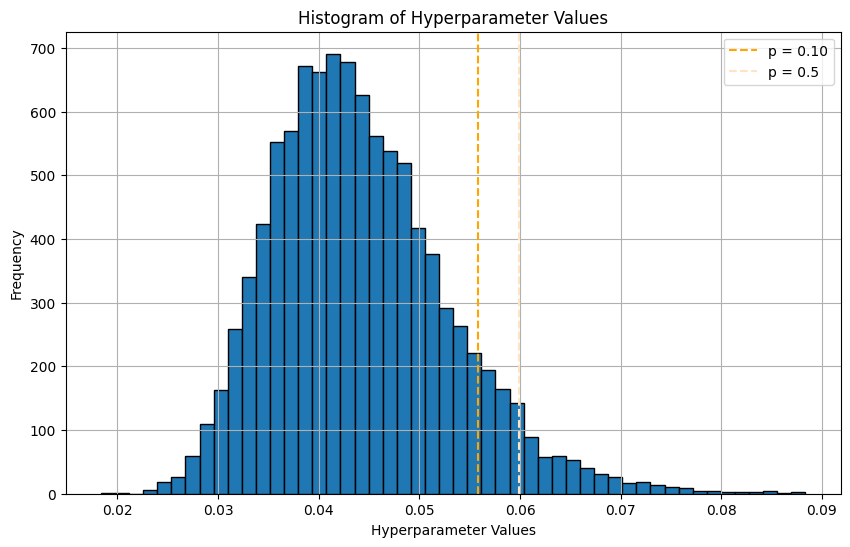

In [ ]:
def hp_p_value_estimator(N, K, markovian):
  hps = []
  if markovian == True:
    for i in range(10000):
      xi = markov_chain_trials(N, K)
      hp = hyperparameter_calculator(xi, N)
      hps.append(hp)
  else:
    for i in range(10000):
      xi = binomial_trials(N, K)
      hp = hyperparameter_calculator(xi, N)
      hps.append(hp)
  return hps

hps = hp_p_value_estimator(N, markov_matrix, markovian=True)
percentile_90 = np.percentile(hps, 90)
# print(f"The 90th percentile of the hyperparameter values is: {percentile_90}")
percentile_95 = np.percentile(hps, 95)
# print(f"The 95th percentile of the hyperparameter values is: {percentile_95}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(hps, bins=50, edgecolor='black')  # Adjust bins as needed
plt.axvline(x=percentile_90, color='orange', linestyle='--', label='p = 0.10')
plt.axvline(x=percentile_95, color='bisque', linestyle='--', label='p = 0.5')
plt.xlabel('Hyperparameter Values')
plt.ylabel('Frequency')
plt.title('Histogram of Hyperparameter Values')
plt.legend()
plt.grid(True)
plt.show()

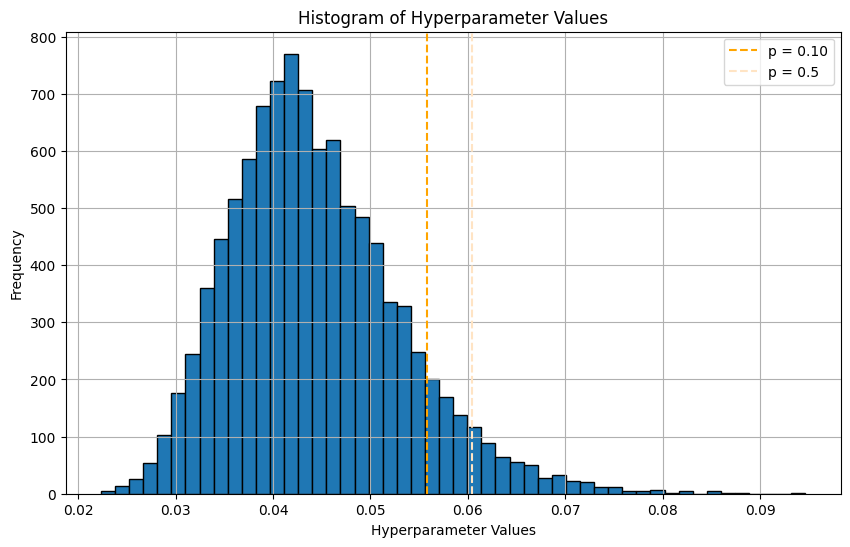

In [ ]:
def hp_p_value_estimator_a(N, markov, frequency, lmbda=0.5):
  """
  Function for bootstrapping with selected value of lambda that weights
  probabilities in the matrix to markovian method (lmbda = 0) or frequency method (lmbda = 1).

  Args:
    N: is the number of trials (ie. total number of scores).
    markov: is the markov matrix under the markovian approach.
    frequency: is the probability of home score under frequency approach.
    lmbda: parameter for weighting.

  Returns:
     A simulated distribution of hyperparameter values.
  """
  hps = []
  ph = markov[0][0]
  pa = markov[1][1]


  K = [[lmbda*frequency + (1-lmbda)*ph, 1 -((lmbda*frequency) + (1-lmbda)*ph)],
                [1 - (lmbda*(1-frequency)+(1-lmbda)*pa), lmbda*(1-frequency) + (1-lmbda)*pa]]
  # print(K)

  for i in range(10000):
    xi = markov_chain_trials(N, K)
    hp = hyperparameter_calculator(xi, N)
    hps.append(hp)

  return hps

N = 100
frequency1 = .5
hps = hp_p_value_estimator_a(N, markov_matrix, frequency1, lmbda=0)

percentile_90 = np.percentile(hps, 90)
# print(f"The 90th percentile of the hyperparameter values is: {percentile_90}")
percentile_95 = np.percentile(hps, 95)
# print(f"The 95th percentile of the hyperparameter values is: {percentile_95}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(hps, bins=50, edgecolor='black')  # Adjust bins as needed
plt.axvline(x=percentile_90, color='orange', linestyle='--', label='p = 0.10')
plt.axvline(x=percentile_95, color='bisque', linestyle='--', label='p = 0.5')
plt.xlabel('Hyperparameter Values')
plt.ylabel('Frequency')
plt.title('Histogram of Hyperparameter Values')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

K = 0.5
N = 100

def binomial_trials(n, k):
    """
    Simulates n binomial trials with a success probability of k/n and returns the number of trials between successes.

    Args:
        n: The total number of trials.
        k: The probability of success.

    Returns:
        A list of the number of trials between successes, or an empty list if there are no successes.
    """
    ##TODO: compartmentalize this into one function with a parameter for randomness vs. actual data - or if too difficult seperate into two.
    if k <= 0 or n <= 0 :
      return []
    trials_between_successes = []
    successes = 0
    trials_since_last_success = 0

    for i in range(n):
        if np.random.rand() > k:
          trials_since_last_success += 1
        else:
          trials_between_successes.append(trials_since_last_success+1)
          trials_since_last_success = 0
    trials_between_successes.append(trials_since_last_success+1) #essentially forces N+1th trial to be a sucess to capture final length.

    return trials_between_successes

xi = binomial_trials(N, K)
# print(xi)
# hp = hyperparameter_calculator(xi)
# print(f'Hyperparameter: {hp}')

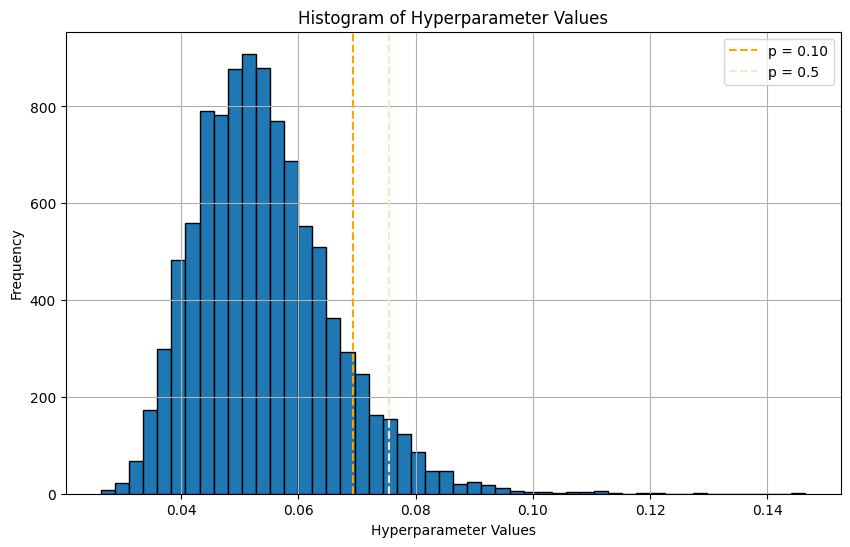

In [ ]:
hps = hp_p_value_estimator(N, K, markovian=False)
# print(hps
percentile_90 = np.percentile(hps, 90)
# print(f"The 90th percentile of the hyperparameter values is: {percentile_90}")
percentile_95 = np.percentile(hps, 95)
# print(f"The 95th percentile of the hyperparameter values is: {percentile_95}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(hps, bins=50, edgecolor='black')  # Adjust bins as needed
plt.axvline(x=percentile_90, color='orange', linestyle='--', label='p = 0.10')
plt.axvline(x=percentile_95, color='bisque', linestyle='--', label='p = 0.5')
plt.xlabel('Hyperparameter Values')
plt.ylabel('Frequency')
plt.title('Histogram of Hyperparameter Values')
plt.legend()
plt.grid(True)
plt.show()



# Data conversion to scores between home scores

In [ ]:
def pbp_to_binom(df):
  # Filter the data
  filtered_df = df[df['EVENTMSGTYPE'] == 1]
  # print(f'Filtered df length: {len(filtered_df)}')

  # Create the pbp_xi column
  binom = filtered_df['HOMEDESCRIPTION'].apply(lambda x: 1 if x =="Home team scored" else 0)
  # print(binom)
  frequency = sum(binom)/binom.count()
  N_value = len(binom)

  # print(f'Frequency: {frequency}')

  # package = tuple((frequency, binom))
  # print(package)

  # return binom
  return N_value, frequency, binom

# N, frequency, binomial = pbp_to_binom(df)
# print(binomial)
# print(frequency)
# print(N)

In [ ]:
def binom_to_xi(binom):
  trials_between_successes = []
  trials_since_last_success = 0

  for p in binom:
    if p == 0:
      trials_since_last_success += 1
    else:
      trials_between_successes.append(trials_since_last_success+1)
      trials_since_last_success = 0
  trials_between_successes.append(trials_since_last_success+1) # forces N+1th trial to be a sucess to capture final length.

  return trials_between_successes

# xi = binom_to_xi(binomial)
# print(xi)
# hp_pbp = hyperparameter_calculator(xi)
# print(hp_pbp)

# Inner game evolution of entropy

In [ ]:
# prompt: I want a code that calculates hp after each play in the pbp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


game_ids = df['URL'].unique()
team_ids = df['HomeTeam'].unique()

for team_id in team_ids[:1]:
  game_ids = df[df['HomeTeam'] == team_id]['URL'].unique()
  # print(game_ids)
  for game_id in game_ids[2:3]:
      game_df = df[df['URL'] == game_id]
      # print(f"Processing game: {game_id}")

      # try:
          # print(game_df.head())
          # Convert PBP to binomial

      pbp_hps = []
      pbp_boot_hps_5 = []
      prev_N = 0
      prev_hp_5 = 0
      for i in range(0,len(game_df), 1):

        N, binomial, frequency = special_pbp_to_binom(game_df.iloc[:i])
        # print(f"Frequency: {frequency}")
        # print(f"N: {N}")
        # print(f"Binomial: {binomial}")

        # Convert binomial to xi
        xi = binom_to_xi(binomial)
        # print(f"xi: {xi}")

        # Calculate hyperparameter
        hp_pbp = hyperparameter_calculator(xi, N)
        pbp_hps.append(hp_pbp)
        # print(f"Hyperparameter for game {game_id}: {hp_pbp}")


        if N > 1: # hp_boot doesnt work for N less than 1
          if N == prev_N: # save on compute by reusing value for same N, also stabilizes the bootstrapped p value
            pbp_boot_hps_5.append(prev_hp_5)
          else:
            hp_boot = hp_p_value_estimator_a(N, markov_matrix, frequency, lmbda=0.5)
            hp_boot_5 = np.percentile(hp_boot, .95)
            prev_hp_5 = hp_boot_5
            pbp_boot_hps_5.append(hp_boot_5)
        else:
          pbp_boot_hps_5.append(1)
        prev_N = N

      game_df = game_df.copy()
      game_df['hp_pbp'] = pbp_hps
      game_df['hp_boot'] = pbp_boot_hps_5
      game_df = time_df(game_df)
      print(game_df.head())


                                URL GameType                         Location  \
29175  /boxscores/201910300TOR.html  regular  Scotiabank Arena Toronto Canada   
29176  /boxscores/201910300TOR.html  regular  Scotiabank Arena Toronto Canada   
29177  /boxscores/201910300TOR.html  regular  Scotiabank Arena Toronto Canada   
29178  /boxscores/201910300TOR.html  regular  Scotiabank Arena Toronto Canada   
29179  /boxscores/201910300TOR.html  regular  Scotiabank Arena Toronto Canada   

                  Date     Time WinningTeam  Quarter  SecLeft AwayTeam  \
29175  October 30 2019  7:30 PM         TOR        1      720      DET   
29176  October 30 2019  7:30 PM         TOR        1      703      DET   
29177  October 30 2019  7:30 PM         TOR        1      686      DET   
29178  October 30 2019  7:30 PM         TOR        1      684      DET   
29179  October 30 2019  7:30 PM         TOR        1      677      DET   

                                                AwayPlay  ...  SCORE

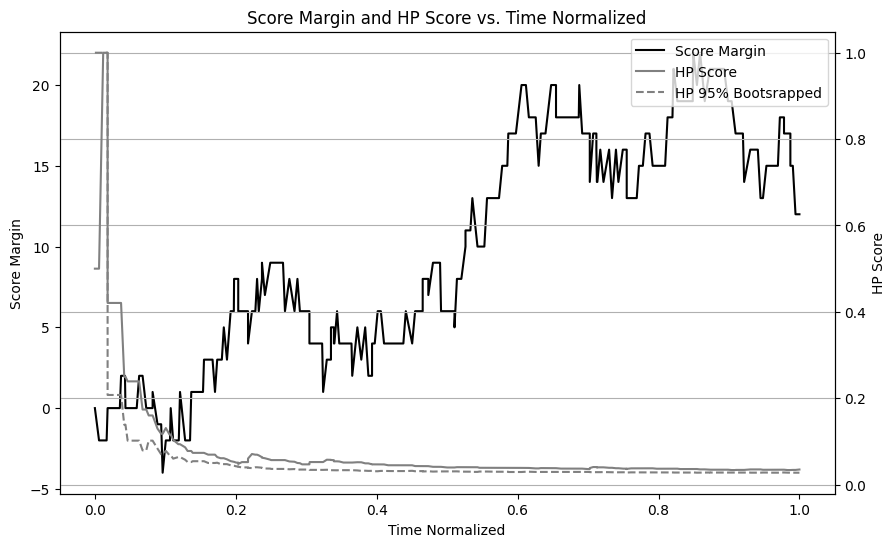

In [ ]:

# Create the line chart
plt.figure(figsize=(10, 6))

# Create the primary y-axis for Score Margin
ax1 = plt.gca()  # Get the current axes
line1, = ax1.plot(game_df['time_normalized'], game_df['SCOREMARGIN'], color='black', label='Score Margin')
ax1.set_xlabel('Time Normalized')
ax1.set_ylabel('Score Margin', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis for HP Score
ax2 = ax1.twinx()
line2, = ax2.plot(game_df['time_normalized'], game_df['hp_pbp'], color='gray', linestyle= "-", label='HP Score')
line3, = ax2.plot(game_df['time_normalized'], game_df['hp_boot'], color='gray', linestyle= "--", label='HP 95% Bootsrapped')
ax2.set_ylabel('HP Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# ax2.set_ylim(0, 0.1)

# Add title and legend
plt.title('Score Margin and HP Score vs. Time Normalized')
lines = [line1, line2, line3]
plt.legend(handles=lines, loc="upper right")
plt.grid(True)
plt.show()


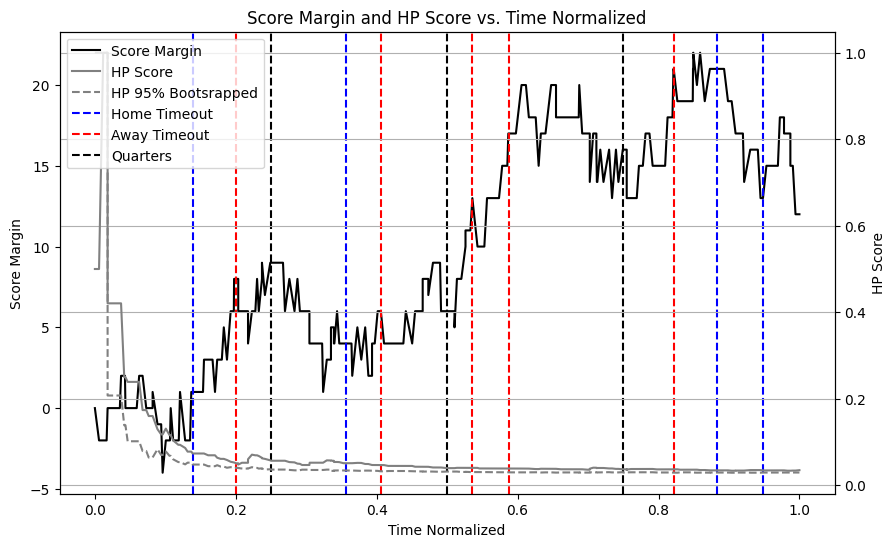

In [ ]:

# Create the line chart
plt.figure(figsize=(10, 6))

# Create the primary y-axis for Score Margin
ax1 = plt.gca()  # Get the current axes
line1, = ax1.plot(game_df['time_normalized'], game_df['SCOREMARGIN'], color='black', label='Score Margin')
ax1.set_xlabel('Time Normalized')
ax1.set_ylabel('Score Margin', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis for HP Score
ax2 = ax1.twinx()
line2, = ax2.plot(game_df['time_normalized'], game_df['hp_pbp'], color='gray', linestyle= "-", label='HP Score')
line3, = ax2.plot(game_df['time_normalized'], game_df['hp_boot'], color='gray', linestyle= "--", label='HP 95% Bootsrapped')
ax2.set_ylabel('HP Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# ax2.set_ylim(0, 0.1)


# Column chart for timeouts
timeout_indices_home = game_df.index[game_df['HOMETIMEOUT'] == 1]
timeout_indices_away = game_df.index[game_df['AWAYTIMEOUT'] == 1]


first = True
for t in timeout_indices_home:
  if first:
    first = False
    line4 = ax1.axvline(x=game_df['time_normalized'][t], color='blue', linestyle='--', label='Home Timeout')
  else:
    ax1.axvline(x=game_df['time_normalized'][t], color='blue', linestyle='--')

first = True
for t in timeout_indices_away:
  if first:
    first = False
    line5 = ax1.axvline(x=game_df['time_normalized'][t], color='Red', linestyle='--', label='Away Timeout')
  else:
    ax1.axvline(x=game_df['time_normalized'][t], color='Red', linestyle='--')

quarter_timeouts = [.25,.5,.75]
first = True
for t in quarter_timeouts:
  if first:
    first = False
    line6 = ax1.axvline(x=t, color='black', linestyle='--', label='Quarters')
  else:
    ax1.axvline(x=t, color='black', linestyle='--')

# Add title and legend
plt.title('Score Margin and HP Score vs. Time Normalized')
lines = [line1, line2, line3, line4, line5, line6]
plt.legend(handles=lines, loc="upper left")
plt.grid(True)
plt.show()


Lazy fixing for above

In [ ]:
def special_pbp_to_binom(df):
  # Filter the data
  filtered_df = df[df['EVENTMSGTYPE'] == 1]
  # print(f'Filtered df length: {len(filtered_df)}')

  # Create the pbp_xi column
  binom = filtered_df['HOMEDESCRIPTION'].apply(lambda x: 1 if x !="" else 0)
  # frequency = sum(binom)/binom.count()
  N_value = 1 if (len(binom)==0) else len(binom)
  frequency = sum(binom)/N_value
  # print(f'Frequency: {frequency}')

  # package = tuple((frequency, binom))
  # print(package)

  # return binom
  return N_value, binom, frequency


# N, frequency, binomial = pbp_to_binom(df)
# print(binomial)
# print(frequency)
# print(N)

# Results and Charts

MARKOVIAN SEASON

In [ ]:
""" MARKOVIAN SEASON """
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

percentile_90_values = []
percentile_95_values = []
hp_pbp_values = []
all_hps_data = []
sim_hp_season = []

game_ids = df['URL'].unique()
team_ids = df['HomeTeam'].unique()



for team_id in team_ids[14:15]:
  game_ids = df[(df['HomeTeam'] == team_id)]['URL'].unique()
  # print(game_ids)
  inner_percentile_90_values = []
  inner_percentile_95_values = []
  inner_hp_pbp_values = []
  inner_all_hps_data = []
  inner_sim_hp_season = []

  for game_id in game_ids:
      game_df = df[df['URL'] == game_id]
      # print(f"Processing game: {game_id}")

      try:
          # print(game_df.head())
          # Convert PBP to binomial
          N, frequency, binomial = pbp_to_binom(game_df)
        #   print(f"Frequency: {frequency}")
        #   print(f"N: {N}")
        #   print(f"Binomial: {binomial}")

          # Convert binomial to xi
          xi = binom_to_xi(binomial)
        #   print(f"xi: {xi}")

          # Calculate hyperparameter
          hp_pbp = hyperparameter_calculator(xi, N)
        #   print(f"Hyperparameter for game {game_id}: {hp_pbp}")

          # Run binomial trials
          hps = hp_p_value_estimator_a(N, markov_matrix, frequency, lmbda=0.24) # Use frequency from pbp_to_binom
          percentile_90 = np.percentile(hps, 90)
          percentile_95 = np.percentile(hps, 95)
           # the idea here is to get a random hp for compairison at season level. - need to think about implementation here.
          rand_draw = np.percentile(hps, np.random.randint(0,100))
          inner_sim_hp_season.append(rand_draw)

          inner_percentile_90_values.append(percentile_90)
          inner_percentile_95_values.append(percentile_95)
          inner_hp_pbp_values.append(hp_pbp)
          inner_all_hps_data.append(hps)
      except Exception as e:
          print(f"Error processing game {game_id}: {e}")
  sim_hp_season.append(inner_sim_hp_season)
  percentile_90_values.append(inner_percentile_90_values)
  percentile_95_values.append(inner_percentile_95_values)
  hp_pbp_values.append(inner_hp_pbp_values)
  all_hps_data.append(inner_all_hps_data)




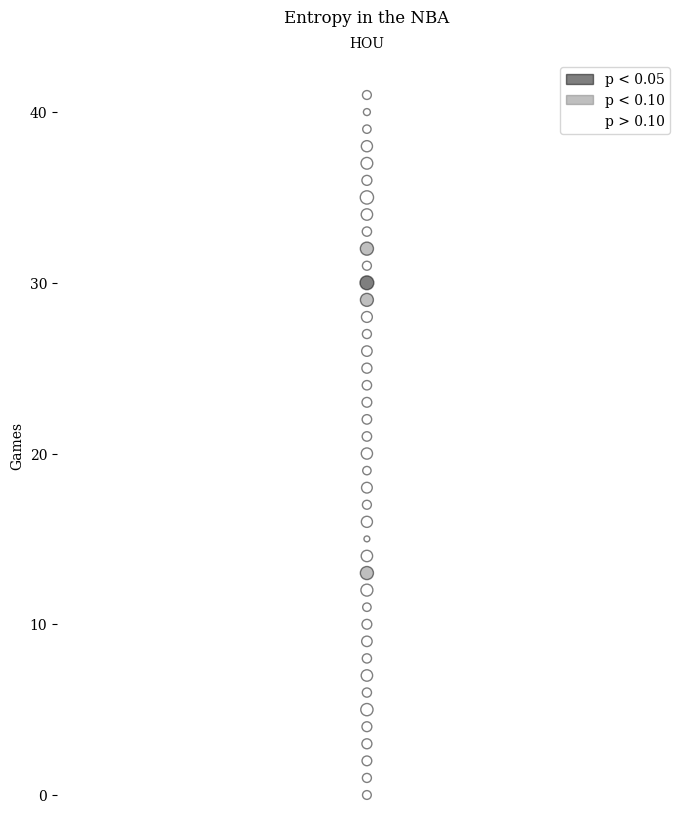

In [ ]:
# prompt: I want a scatter plot of random values with a 3rd dimension defining area size

import matplotlib.pyplot as plt
import numpy as np

first_list = []
second_list = []
third_list = []

facecolors = []
edgecolors = []

scalar=100

for i in range(1):
  max_hp = max(hp_pbp_values[i])
  for j in range(len(hp_pbp_values[i])):
    first_list.append(i)
    second_list.append(j)
    third_list.append((hp_pbp_values[i][j]**2/max_hp**2)*scalar)
    if hp_pbp_values[i][j] > percentile_95_values[i][j]:
      facecolors.append('black')
    elif hp_pbp_values[i][j] > percentile_90_values[i][j]:
      facecolors.append('gray')
    else:
      facecolors.append('white')
    edgecolors.append('black')

# Generate random data
x = first_list
y = second_list
area = third_list # Area values
# label = team_ids


plt.rcParams["font.family"] = "DejaVu Serif" # Create the scatter plot
plt.figure(figsize=(8, 10))


plt.scatter(x, y, s=area, alpha=0.5, facecolors=facecolors, edgecolors=edgecolors)



# Customize the plot
# plt.xlabel("X-axis")
plt.ylabel("Games")
plt.title("Entropy in the NBA", pad=10)
plt.grid(False)
plt.box(False)
plt.xticks(range(1), labels=[team_ids[14]], rotation=0)
plt.tick_params(axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labeltop=True,
                labelbottom=False) # labels along the bottom edge are off

# Create custom legend
import matplotlib.patches as mpatches
black_patch = mpatches.Patch(color='black', alpha=0.5, label='p < 0.05') #added alpha to make the colors correspond
gray_patch = mpatches.Patch(color='gray', alpha=0.5, label='p < 0.10')
white_patch = mpatches.Patch(color='white', alpha=0.5, label='p > 0.10')

plt.legend(handles=[black_patch, gray_patch, white_patch], loc='upper right')


plt.savefig("scatter_plot.svg", format="svg")
# Show the plot
plt.show()

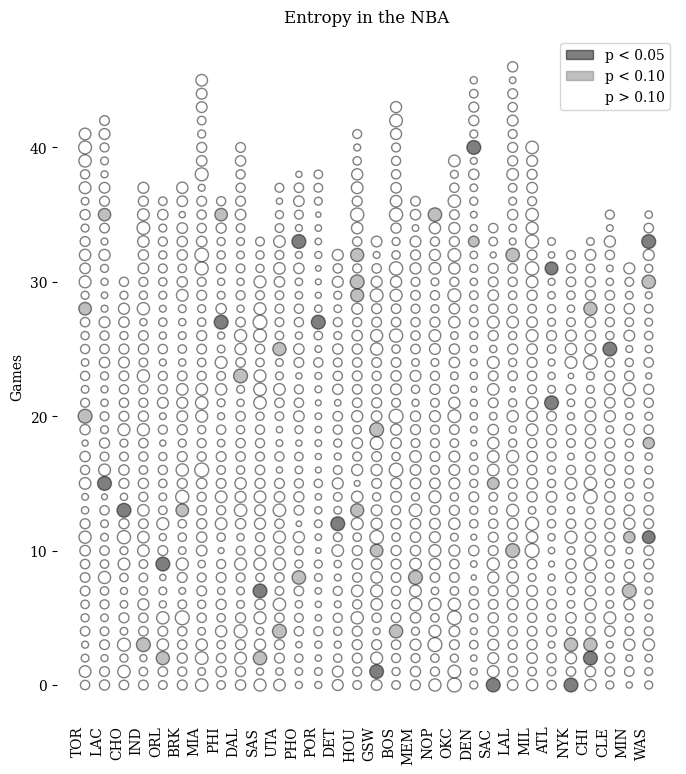

In [ ]:
# prompt: the xticks labels are overlapping how can i fix this?

import matplotlib.pyplot as plt
# ... (Your existing code) ...

# Generate random data
x = first_list
y = second_list
area = third_list  # Area values
label = team_ids

plt.rcParams["font.family"] = "DejaVu Serif"  # Create the scatter plot
plt.figure(figsize=(8, 10))

plt.scatter(x, y, s=area, alpha=0.5, facecolors=facecolors, edgecolors=edgecolors)

# Customize the plot
# plt.xlabel("X-axis")
plt.ylabel("Games")
plt.title("Entropy in the NBA", pad=10)
plt.grid(False)
plt.box(False)

# Fix overlapping xticks by rotating and adjusting spacing
plt.xticks(range(30), labels=label, rotation=90, ha='right')  # Rotate labels 90 degrees
plt.tick_params(axis='x', which='both', bottom=False, top=False, labeltop=False, labelbottom=True)
plt.subplots_adjust(bottom=0.2)  # Add more space at the bottom for labels

# Create custom legend
black_patch = mpatches.Patch(color='black', alpha=0.5, label='p < 0.05')  # added alpha to make the colors correspond
gray_patch = mpatches.Patch(color='gray', alpha=0.5, label='p < 0.10')
white_patch = mpatches.Patch(color='white', alpha=0.5, label='p > 0.10')

plt.legend(handles=[black_patch, gray_patch, white_patch], loc='upper right')

plt.savefig("scatter_plot.svg", format="svg")
# Show the plot
plt.show()


In [ ]:
import pandas as pd


def save_list_to_csv(data, filename, team_ids):
  """Saves a list of lists to a CSV file.

  Args:
    data: The list of lists to save.
    filename: The name of the CSV file to create.
  """
  try:
    for i, team_id in enumerate(team_ids):
      with open(f"{filename}_{team_id}.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        for row in data[i]:
          writer.writerow(row)
  except Exception as e:
    print(f"Error saving data to CSV: {e}")

sim_hp_season.to_csv('sim_hp_season.csv', index=False)
percentile_90_values.to_csv('percentile_90_values.csv', index=False)
percentile_95_values.to_csv('percentile_95_values.csv', index=False)
hp_pbp_values.to_csv('hp_pbp_values.csv', index=False)


AttributeError: 'list' object has no attribute 'to_csv'

In [ ]:
import pandas as pd

# Assuming sim_hp_season is your list of lists
sim_hp_season_df = pd.DataFrame(sim_hp_season)  # Create a DataFrame from the list

# Now you can save it to CSV
sim_hp_season_df.to_csv('sim_hp_season.csv', index=False)

# Similar process for other list variables:
percentile_90_values_df = pd.DataFrame(percentile_90_values)
percentile_90_values_df.to_csv('percentile_90_values.csv', index=False)

percentile_95_values_df = pd.DataFrame(percentile_95_values)
percentile_95_values_df.to_csv('percentile_95_values.csv', index=False)

hp_pbp_values_df = pd.DataFrame(hp_pbp_values)
hp_pbp_values_df.to_csv('hp_pbp_values.csv', index=False)

In [ ]:
# prompt: I need to store a list of lists (all_hp_data) in a csv. The hierarchy is based on team (n=2), game (n=82), and simulation (n=10000).

import csv

def save_list_of_lists_to_csv(data, filename, team_ids):
  """Saves a list of lists to a CSV file.

  Args:
    data: The list of lists to save.
    filename: The name of the CSV file to create.
  """
  try:
    for i, team_id in enumerate(team_ids):
      with open(f"{filename}_{team_id}.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        for row in data[i]:
          writer.writerow(row)
  except Exception as e:
    print(f"Error saving data to CSV: {e}")

# Example usage (assuming 'all_hp_data' is your list of lists):
save_list_of_lists_to_csv(all_hps_data, 'all_hps_data.csv', team_ids[:2])


In [ ]:
ps_list = []
wins = []

game_ids = df['URL'].unique()
h_team_ids = df['HomeTeam'].unique()

# for team_id in team_ids:
#   game_ids = df[(df['HomeTeam'] == team_id) | (df['AwayTeam'] == team_id)]['URL'].unique()

for team_id in team_ids: #only home games
  game_ids = df[df['HomeTeam'] == team_id]['URL'].unique()

  inner_ps_list = []
  inner_wins = []

  for game_id in game_ids:
      game_df = df[df['URL'] == game_id]
      # print(f"Processing game: {game_id}")
      try:
        if game_df['WinningTeam'].iloc[0] == team_id:
          inner_wins.append(1)
        else:
          inner_wins.append(0)
        N, frequency, binomial = pbp_to_binom(game_df)
        inner_ps_list.append(frequency)
      except Exception as e:
          print(f"Error processing game {game_id}: {e}")
  ps_list.append(inner_ps_list)
  wins.append(inner_wins)

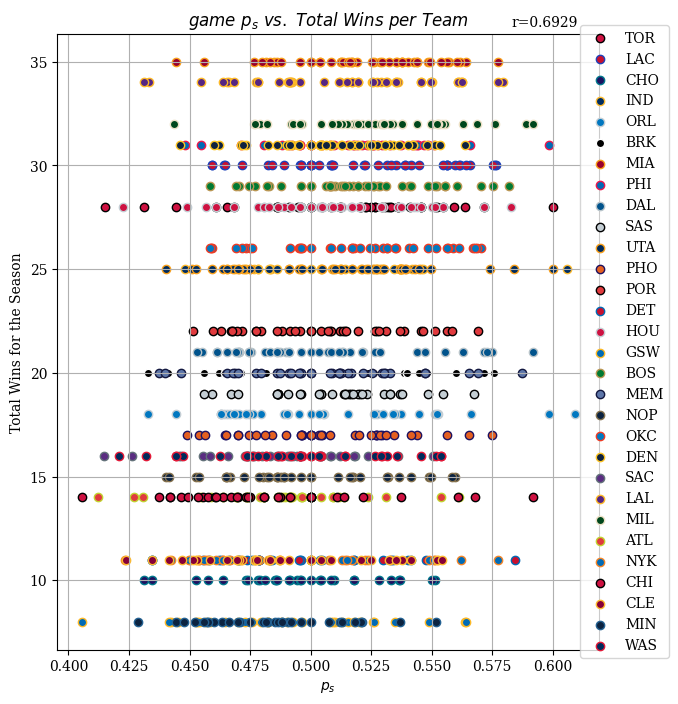

In [ ]:
# prompt: I have two lists of lists. One holds ps values, the other is binary hokding wins for the respective ps. The list hierarchy indicates which teams. I want to scatter plot each teams total wins, against the various ps values.

import matplotlib.pyplot as plt
import numpy as np

# Assuming ps_list and wins are defined as in your provided code

# Create the plot
plt.figure(figsize=(7, 8))

for i in range(len(ps_list)):
  total_wins = np.sum(wins[i])
  plt.scatter(ps_list[i], [total_wins] * len(ps_list[i]), label=team_ids[i], color=nba_team_colors[team_ids[i]]['primary'], edgecolors=nba_team_colors[team_ids[i]]['secondary'])  # Scatter plot with total_wins repeated for each point

textstring = r"$p_s$"
textstring2 = r"$game\ p_s\ vs.\ Total\ Wins\ per\ Team$"
textstring3 = r"r=0.6929"


plt.text(0.96,1.03,textstring3, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)
plt.xlabel(textstring)
plt.ylabel("Total Wins for the Season")
plt.title(textstring2)
plt.legend(loc="right", borderaxespad=-5) # Add legend to distinguish teams
plt.grid(True)
plt.show()


In [ ]:
# prompt: i want code that tells me how predictive the value of ps_list is to determining total_wins

import numpy as np
import matplotlib.pyplot as plt

# Calculate correlation coefficients for each team
correlations = []
for i in range(len(ps_list)):
  correlation = np.corrcoef(ps_list[i], wins[i])[0, 1]
  correlations.append(correlation)

print("Correlation coefficients for each team:")
for i, correlation in enumerate(correlations):
    print(f"Team {team_ids[i]}: {correlation}")

# Calculate the overall correlation across all teams
all_ps_values = [ps for sublist in ps_list for ps in sublist]
all_wins_values = [win for sublist in wins for win in sublist]

overall_correlation = np.corrcoef(all_ps_values, all_wins_values)[0, 1]

print(f"\nOverall correlation across all teams: {overall_correlation}")


Correlation coefficients for each team:
Team TOR: 0.7393139738187403
Team LAC: 0.5845509651378519
Team CHO: 0.5600318583356454
Team IND: 0.7529987291858526
Team ORL: 0.8000014113231224
Team BRK: 0.7945297348534501
Team MIA: 0.5886544231786182
Team PHI: 0.5323421435509724
Team DAL: 0.7428636801240894
Team SAS: 0.5344772366570271
Team UTA: 0.7017520047065701
Team PHO: 0.5959115214357273
Team POR: 0.687300355163739
Team DET: 0.7783393079708699
Team HOU: 0.671427352305384
Team GSW: 0.7025728281247101
Team BOS: 0.6263440841835762
Team MEM: 0.6311551926816892
Team NOP: 0.724826408851691
Team OKC: 0.6484130005056561
Team DEN: 0.705231915321795
Team SAC: 0.5735356702945299
Team LAL: 0.7089084740095452
Team MIL: 0.5498696376490603
Team ATL: 0.5864430167096729
Team NYK: 0.6623667673981625
Team CHI: 0.6616243894294964
Team CLE: 0.8176686105704075
Team MIN: 0.6316768184548202
Team WAS: 0.6528346455980375

Overall correlation across all teams: 0.6929145726560763


In [ ]:
# prompt: make the lists nba_team_abbreviations and nba_teams correspond to each other, such that I can use the abbreviation to find a color.

nba_team_colors = {}
for team, abbreviation in nba_team_abbreviations.items():
    if team in nba_teams:
        nba_team_colors[abbreviation] = nba_teams[team]
    else:
        print(f"Team '{team}' not found in nba_teams dictionary.")
nba_team_colors

{'ATL': {'primary': '#E03A3E', 'secondary': '#C1D32F'},
 'BOS': {'primary': '#007A33', 'secondary': '#BA9653'},
 'BRK': {'primary': '#000000', 'secondary': '#FFFFFF'},
 'CHO': {'primary': '#1D1160', 'secondary': '#00788C'},
 'CHI': {'primary': '#CE1141', 'secondary': '#000000'},
 'CLE': {'primary': '#860038', 'secondary': '#FDBB30'},
 'DAL': {'primary': '#00538C', 'secondary': '#B8C4CA'},
 'DEN': {'primary': '#0E2240', 'secondary': '#FEC524'},
 'DET': {'primary': '#C8102E', 'secondary': '#006BB6'},
 'GSW': {'primary': '#006BB6', 'secondary': '#FDB927'},
 'HOU': {'primary': '#CE1141', 'secondary': '#C4CED4'},
 'IND': {'primary': '#002D62', 'secondary': '#FDBB30'},
 'LAC': {'primary': '#C8102E', 'secondary': '#1D42BA'},
 'LAL': {'primary': '#552583', 'secondary': '#FDB927'},
 'MEM': {'primary': '#5D76A9', 'secondary': '#12173F'},
 'MIA': {'primary': '#98002E', 'secondary': '#F9A01B'},
 'MIL': {'primary': '#00471B', 'secondary': '#EEE1C6'},
 'MIN': {'primary': '#0C2340', 'secondary': '#23

In [ ]:
from scipy import stats


for i in range(len(hp_pbp)):
  t_statistic, p_value = stats.ttest_ind(ps_list[i], wins[i])
# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(hp_pbp, sim_hp_season)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: 0.9984006208264881
P-value: 0.3239413750669218


In [ ]:
from scipy import stats

# Perform Mann-Whitney U test
u_statistic, p_value = stats.mannwhitneyu(hp_pbp_values[0], sim_hp_season[0])

print(f"U-statistic: {u_statistic}")
print(f"P-value: {p_value}")

U-statistic: 958.0
P-value: 0.49940411723976763


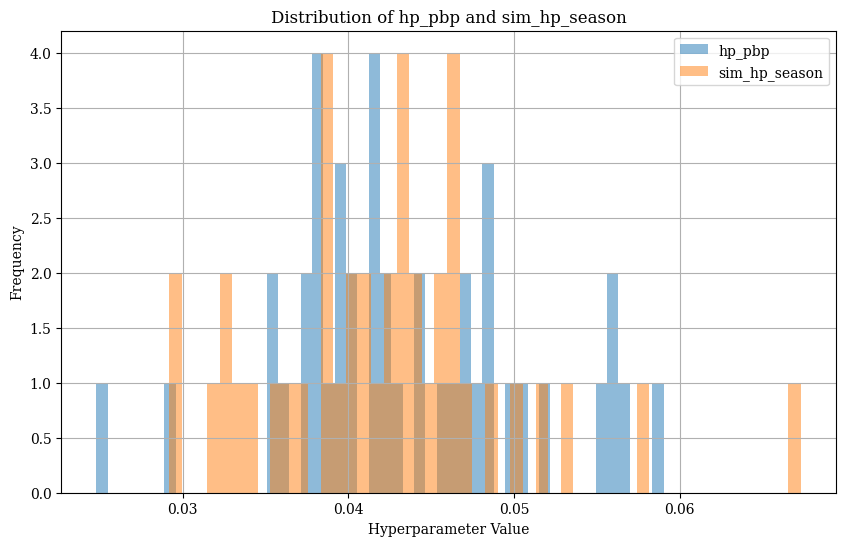

In [ ]:
# prompt: I want to plot the distributions of hp_pbp and sim_hp_season on the same y axis

import matplotlib.pyplot as plt

# Assuming hp_pbp and sim_hp_season are defined in your code
# Replace these with your actual data if needed

# Create the plot
plt.figure(figsize=(10, 6))

plt.hist(hp_pbp_values[0], bins=50, alpha=0.5, label='hp_pbp')
plt.hist(sim_hp_season[0], bins=50, alpha=0.5, label='sim_hp_season')

plt.xlabel('Hyperparameter Value')
plt.ylabel('Frequency')
plt.title('Distribution of hp_pbp and sim_hp_season')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


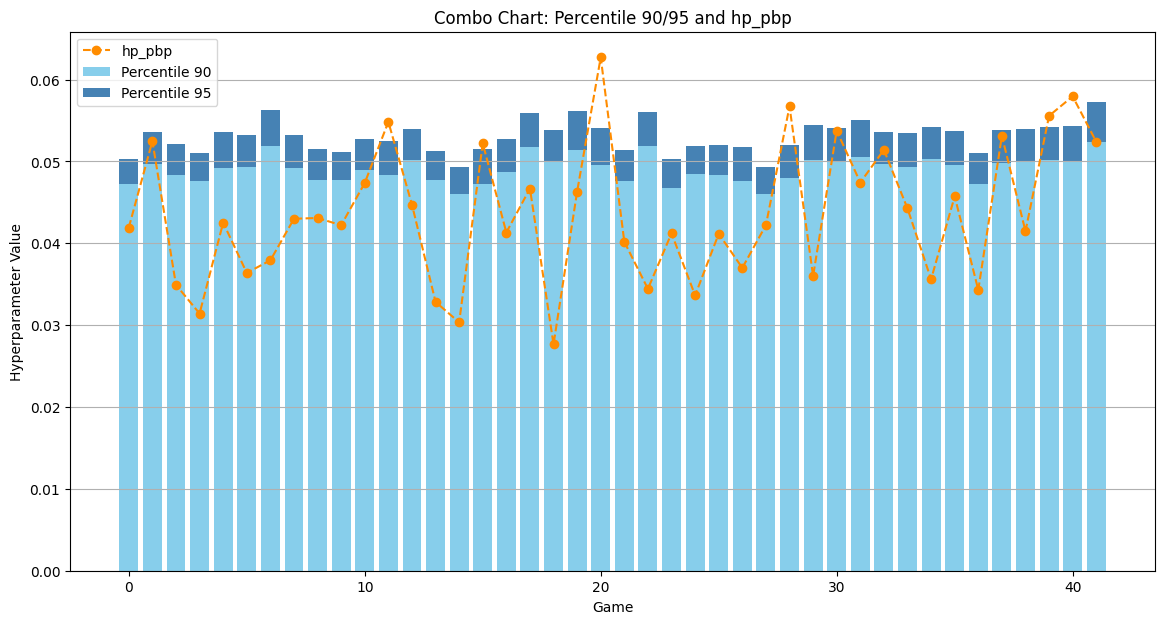

In [ ]:
import matplotlib.pyplot as plt

# Assuming percentile_90_values, percentile_95_values, and hp_pbp_values are already populated from the previous code execution.

plt.figure(figsize=(14, 7))

dif_percentile_95 = [x - y for x, y in zip(percentile_90_values, percentile_95_values)]

# Stacked Column Chart
plt.bar(range(len(percentile_90_values[0])), percentile_90_values[], label='Percentile 90', color='skyblue')
plt.bar(range(len(dif_percentile_95)), dif_percentile_95, bottom=percentile_90_values, label='Percentile 95', color='steelblue')

# Line Chart
plt.plot(range(len(hp_pbp_values)), hp_pbp_values, marker='o', linestyle='--', color='darkorange', label='hp_pbp')

# Customize the chart
plt.xlabel('Game')
plt.ylabel('Hyperparameter Value')
plt.title('Combo Chart: Percentile 90/95 and hp_pbp')
plt.legend(facecolor="white")
plt.grid(True, axis='y')
plt.show()

In [ ]:
from scipy.stats import gaussian_kde
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

# list_of_lists = []

# for i in range(8):
#   inner_list = []
#   for j in range(150):
#     inner_list.append(np.random.normal(i, 1))
#   list_of_lists.append(inner_list)
# # print(list_of_lists)

alpha_hps = []
alpha_hps_5 = []


for j in range(3):
  for i in range(0,11,1):
    hps = hp_p_value_estimator_a(N, markov_matrix, ((4+j)/10), lmbda=i/10)
    percentile_90 = np.percentile(hps, 90)

    alpha_hps.append(hps)
    alpha_hps_5.append(percentile_90)

In [ ]:
lmbda_labels = []
for j in range(3):
  for i in range(0,11,1):
    lmbda_labels.append(i/10)

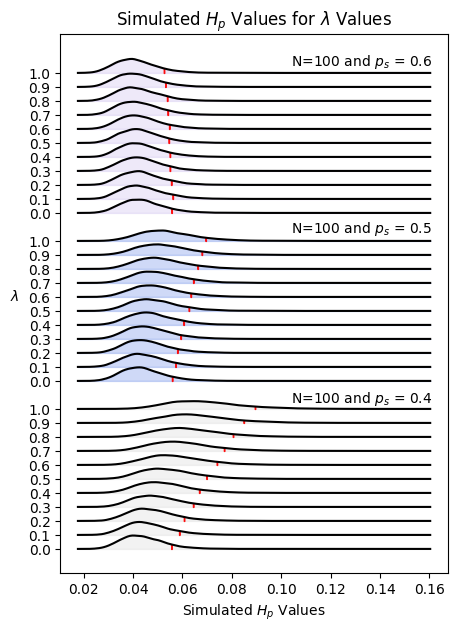

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def ridgeline(data, lines, overlap=0, fill=True, labels=None, n_points=150):
    """
    Creates a ridgeline plot with scaled y-values.

    Args:
        data: List of lists, where each inner list represents a distribution.
        lines: List of values representing the lines to draw on each distribution.
        overlap: Overlap between distributions (0 to 1).
        fill: Matplotlib color to fill the distributions.
        labels: Labels for the y-axis.
        n_points: Number of points to evaluate each distribution function.
    """

    if overlap > 1 or overlap < 0:
        raise ValueError('overlap must be in [0 1]')

    xx = np.linspace(np.min(np.concatenate(data)), np.max(np.concatenate(data)), n_points)
    curves = []
    ys = []
    max_density = 0  # Find the maximum density across all distributions

    for d in data:
        pdf = gaussian_kde(d)
        max_density = max(max_density, pdf(xx).max())

    ii = 0
    for i, d in enumerate(data):
        if i % 11 == 0:
          ii = ii + 1
        iii = i + ii

        pdf = gaussian_kde(d)
        y = iii * (1.0 - overlap)
        ys.append(y)
        curve = pdf(xx)
        # Scale the curve to have a maximum height of 1
        scaled_curve = curve / max_density
        lines_list = [lines[i]-0.0001, lines[i], lines[i]+0.0001]
        curve_at_lines = pdf(lines_list) / max_density # scale the lines too.
        if fill:
            if i < 11:
              plt.fill_between(xx, np.ones(n_points)*y, scaled_curve+y, zorder=len(data)-i+1, color=fill, alpha=0.35)
            elif i < 22:
              plt.fill_between(xx, np.ones(n_points)*y, scaled_curve+y, zorder=len(data)-i+1, color='royalblue', alpha=0.25)
            else:
              plt.fill_between(xx, np.ones(n_points)*y, scaled_curve+y, zorder=len(data)-i+1, color='mediumpurple', alpha=0.15)
            plt.fill_between(lines_list, np.ones(3)*y, curve_at_lines+y, zorder=len(data)-i+1, color="red", alpha=0.9)

        plt.plot(xx, scaled_curve+y, c='k', zorder=len(data)-i+1)

    if labels:
        plt.yticks(ys, labels)


# Example usage (replace with your actual data)
ovrlp = 0
plt.figure(figsize=(5, 7))
ridgeline(alpha_hps, alpha_hps_5, overlap=ovrlp, fill="Gainsboro", labels=lmbda_labels, n_points=150)

textstring4 = r"Simulated $H_p$ Values"
textstring5 = r"$\lambda$"
textstring6 = r"Simulated $H_p$ Values for $\lambda$ Values"

plt.xlabel(textstring4)
plt.ylabel(textstring5, rotation=0, labelpad=10)
plt.title(textstring6)

textstring = r"N=100 and $p_s$ = 0.6"
textstring2 = r"N=100 and $p_s$ = 0.5"
textstring3 = r"N=100 and $p_s$ = 0.4"


plt.text(0.96,0.965,textstring, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)
plt.text(0.96,0.655,textstring2, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)
plt.text(0.96,0.34,textstring3, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)



plt.show()


In [ ]:
# prompt: pad the y label from the chart

import matplotlib.pyplot as plt
# ... (Your existing code) ...

plt.rcParams["font.family"] = "DejaVu Serif"  # Create the scatter plot
plt.figure(figsize=(8, 10))

plt.scatter(x, y, s=area, alpha=0.5, facecolors=facecolors, edgecolors=edgecolors)

# Customize the plot
# plt.xlabel("X-axis")
plt.ylabel("Games", labelpad=10)  # Add padding to the ylabel
plt.title("Entropy in the NBA", pad=10)
plt.grid(False)
plt.box(False)

# Fix overlapping xticks by rotating and adjusting spacing
plt.xticks(range(30), labels=label, rotation=90, ha='right')  # Rotate labels 90 degrees
plt.tick_params(axis='x', which='both', bottom=False, top=False, labeltop=False, labelbottom=True)
plt.subplots_adjust(bottom=0.2)  # Add more space at the bottom for labels

# Create custom legend
black_patch = mpatches.Patch(color='black', alpha=0.5, label='p < 0.05')  # added alpha to make the colors correspond
gray_patch = mpatches.Patch(color='gray', alpha=0.5, label='p < 0.10')
white_patch = mpatches.Patch(color='white', alpha=0.5, label='p > 0.10')

plt.legend(handles=[black_patch, gray_patch, white_patch], loc='upper right')

plt.savefig("scatter_plot.svg", format="svg")
# Show the plot
plt.show()

# ... (Rest of your code) ...


In [ ]:
from scipy.stats import gaussian_kde
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

# list_of_lists = []

# for i in range(8):
#   inner_list = []
#   for j in range(150):
#     inner_list.append(np.random.normal(i, 1))
#   list_of_lists.append(inner_list)
# # print(list_of_lists)

alpha_hpss = []
alpha_hps_5s = []


for i in range(0,11,1):
  hps = hp_p_value_estimator_a(N, markov_matrix, 0.6, lmbda=i/10)
  percentile_90 = np.percentile(hps, 90)

  alpha_hpss.append(hps)
  alpha_hps_5s.append(percentile_90)

In [ ]:
lmbda_labelss = []
for i in range(0,11,1):
  lmbda_labelss.append(i/10)

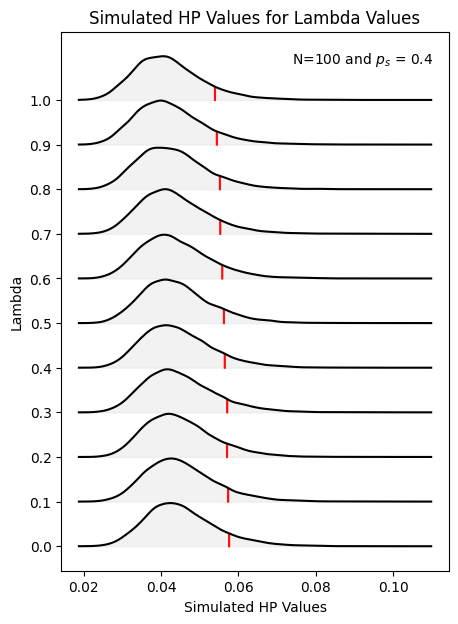

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def ridgeline(data, lines, overlap=0, fill=True, labels=None, n_points=150):
    """
    Creates a ridgeline plot with scaled y-values.

    Args:
        data: List of lists, where each inner list represents a distribution.
        lines: List of values representing the lines to draw on each distribution.
        overlap: Overlap between distributions (0 to 1).
        fill: Matplotlib color to fill the distributions.
        labels: Labels for the y-axis.
        n_points: Number of points to evaluate each distribution function.
    """

    if overlap > 1 or overlap < 0:
        raise ValueError('overlap must be in [0 1]')

    xx = np.linspace(np.min(np.concatenate(data)), np.max(np.concatenate(data)), n_points)
    curves = []
    ys = []
    max_density = 0  # Find the maximum density across all distributions

    for d in data:
        pdf = gaussian_kde(d)
        max_density = max(max_density, pdf(xx).max())


    for i, d in enumerate(data):

        pdf = gaussian_kde(d)
        y = i * (1.0 - overlap)
        ys.append(y)
        curve = pdf(xx)
        # Scale the curve to have a maximum height of 1
        scaled_curve = curve / max_density
        lines_list = [lines[i]-0.0001, lines[i], lines[i]+0.0001]
        curve_at_lines = pdf(lines_list) / max_density # scale the lines too.
        if fill:
              plt.fill_between(xx, np.ones(n_points)*y, scaled_curve+y, zorder=len(data)-i+1, color=fill, alpha=0.35)
              plt.fill_between(lines_list, np.ones(3)*y, curve_at_lines+y, zorder=len(data)-i+1, color="red", alpha=0.9)

        plt.plot(xx, scaled_curve+y, c='k', zorder=len(data)-i+1)

    if labels:
        plt.yticks(ys, labels)


# Example usage (replace with your actual data)
ovrlp = 0
plt.figure(figsize=(5, 7))
ridgeline(alpha_hpss, alpha_hps_5s, overlap=ovrlp, fill="Gainsboro", labels=lmbda_labelss, n_points=150)

plt.xlabel('Simulated HP Values')
plt.ylabel('Lambda')
plt.title('Simulated HP Values for Lambda Values')

textstring3 = r"N=100 and $p_s$ = 0.4"

plt.text(0.96,0.965,textstring3, verticalalignment='top', horizontalalignment='right', transform=plt.gca().transAxes)



plt.show()


NON MARKOVIAN ESTIMATOR

In [ ]:
""" NON MARKOVIAN SEASON """
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

percentile_90_values = []
percentile_95_values = []
hp_pbp_values = []

game_ids = df['GAME_ID'].unique()
team_ids = df['HOME_TEAM_NAME'].unique()



for team_id in team_ids[:1]:
  game_ids = df[df['HOME_TEAM_NAME'] == team_id]['GAME_ID'].unique()
  # print(game_ids)
  for game_id in game_ids:
      game_df = df[df['GAME_ID'] == game_id]
      # print(f"Processing game: {game_id}")

      try:
          print(game_df.head())
          # Convert PBP to binomial
          N, frequency, binomial = pbp_to_binom(game_df)
          print(f"Frequency: {frequency}")
          print(f"N: {N}")
          print(f"Binomial: {binomial}")

          # Convert binomial to xi
          xi = binom_to_xi(binomial)
          print(f"xi: {xi}")

          # Calculate hyperparameter
          hp_pbp = hyperparameter_calculator(xi)
          print(f"Hyperparameter for game {game_id}: {hp_pbp}")

          # Run binomial trials
          hps = hp_p_value_estimator(N, frequency, markovian=False) # Use frequency from pbp_to_binom
          percentile_90 = np.percentile(hps, 90)
          percentile_95 = np.percentile(hps, 95)

          percentile_90_values.append(percentile_90)
          percentile_95_values.append(percentile_95)
          hp_pbp_values.append(hp_pbp)

      except Exception as e:
          print(f"Error processing game {game_id}: {e}")

    GAME_ID  EVENTNUM  EVENTMSGTYPE  EVENTMSGACTIONTYPE  PERIOD WCTIMESTRING  \
0  42300405         2            12                   0       1      8:39 PM   
1  42300405         4            10                   0       1      8:39 PM   
2  42300405         7             1                   6       1      8:39 PM   
3  42300405         9             2                  80       1      8:39 PM   
4  42300405        10             4                   0       1      8:40 PM   

  PCTIMESTRING                                 HOMEDESCRIPTION  \
0        12:00                                                   
1        12:00     Jump Ball Horford vs. Gafford: Tip to Brown   
2        11:40  Holiday 1' Driving Layup (2 PTS) (Tatum 1 AST)   
3        11:23                                                   
4        11:22                     Tatum REBOUND (Off:0 Def:1)   

                  NEUTRALDESCRIPTION                       VISITORDESCRIPTION  \
0  Start of 1st Period (8:39 PM EST)     

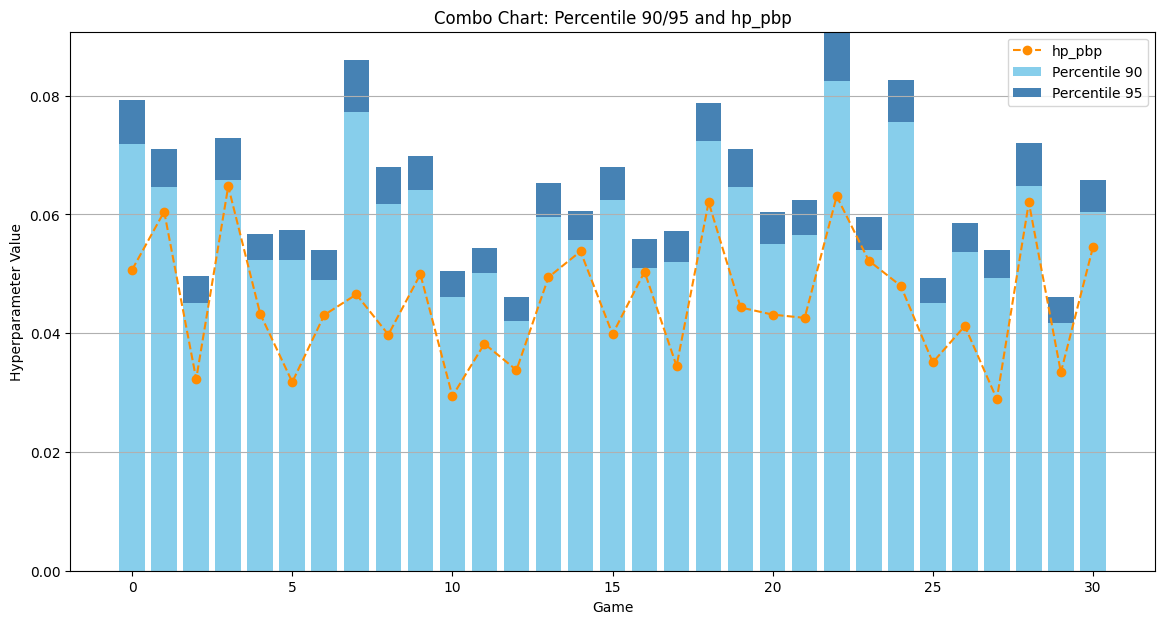

In [ ]:
import matplotlib.pyplot as plt

# Assuming percentile_90_values, percentile_95_values, and hp_pbp_values are already populated from the previous code execution.

plt.figure(figsize=(14, 7))

dif_percentile_95 = [x - y for x, y in zip(percentile_90_values, percentile_95_values)]

# Stacked Column Chart
plt.bar(range(len(percentile_90_values)), percentile_90_values, label='Percentile 90', color='skyblue')
plt.bar(range(len(dif_percentile_95)), dif_percentile_95, bottom=percentile_90_values, label='Percentile 95', color='steelblue')

# Line Chart
plt.plot(range(len(hp_pbp_values)), hp_pbp_values, marker='o', linestyle='--', color='darkorange', label='hp_pbp')

# Customize the chart
plt.xlabel('Game')
plt.ylabel('Hyperparameter Value')
plt.title('Combo Chart: Percentile 90/95 and hp_pbp')
plt.legend()
plt.grid(True, axis='y')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


franchise = []
insig_count = []
sig_10_count = []
sig_5_count = []
sig_1_count = []
game_ids = df['GAME_ID'].unique()
team_ids = df['HOME_TEAM_NAME'].unique()



for team_id in team_ids:
  game_ids = df[df['HOME_TEAM_NAME'] == team_id]['GAME_ID'].unique()
  # print(game_ids)

  percentile_90_values = []
  percentile_95_values = []
  percentile_99_values = []
  hp_pbp_values = []


  for game_id in game_ids:
      game_df = df[df['GAME_ID'] == game_id]
      # print(f"Processing game: {game_id}")
      try:
          # Convert PBP to binomial
          N, frequency, binomial = pbp_to_binom(game_df)

          # Convert binomial to xi
          xi = binom_to_xi(binomial)

          # Calculate hyperparameter
          hp_pbp = hyperparameter_calculator(xi)
          # print(f"Hyperparameter for game {game_id}: {hp_pbp}")

          # Run binomial trials
          hps = hp_p_value_estimator(N, average_markov_matrix, markovian=True) # Use frequency from pbp_to_binom
          percentile_90 = np.percentile(hps, 90)
          percentile_95 = np.percentile(hps, 95)
          percentile_99 = np.percentile(hps, 99)

          percentile_90_values.append(percentile_90)
          percentile_95_values.append(percentile_95)
          percentile_99_values.append(percentile_99)
          hp_pbp_values.append(hp_pbp)

      except Exception as e:
          print(f"Error processing game {game_id}: {e}")
  insig_sum = 0
  sig_10_sum = 0
  sig_5_sum = 0
  sig_1_sum = 0
  for hp in hp_pbp_values:
    if hp > percentile_99:
      sig_1_sum += 1
    elif hp > percentile_95:
      sig_5_sum += 1
    elif hp > percentile_90:
      sig_10_sum += 1
    else:
      insig_sum += 1
  franchise.append(team_id)
  insig_count.append(insig_sum)
  sig_10_count.append(sig_10_sum)
  sig_5_count.append(sig_5_sum)
  sig_1_count.append(sig_1_sum)


In [ ]:
# prompt: make a csv out of all the lists above

import pandas as pd

# Assuming your lists are named franchise, insig_count, sig_10_count, sig_5_count, and sig_1_count
data = {
    'Franchise': franchise,
    'Insignificant': insig_count,
    'Significant_10': sig_10_count,
    'Significant_5': sig_5_count,
    'Significant_1': sig_1_count
}

df_results = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df_results.to_csv('nba_analysis_results.csv', index=False)


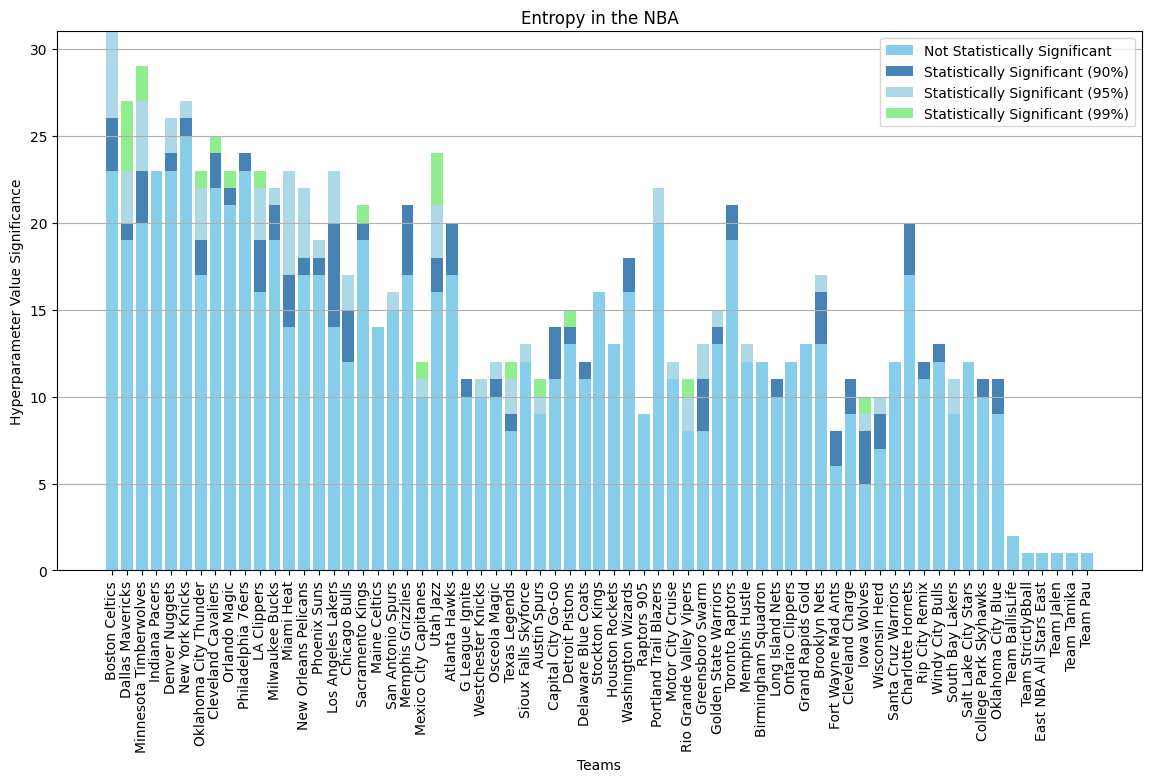

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))



# Stacked Column Chart
plt.bar(range(len(insig_count)), insig_count, label='Not Statistically Significant', color='skyblue')
plt.bar(range(len(sig_10_count)), sig_10_count, bottom=insig_count, label='Statistically Significant (90%)', color='steelblue')
plt.bar(range(len(sig_5_count)), sig_5_count, bottom=[x + y for x, y in zip(insig_count, sig_10_count)], label='Statistically Significant (95%)', color='lightblue')
plt.bar(range(len(sig_1_count)), sig_1_count, bottom=[x + y + z for x, y, z in zip(insig_count, sig_10_count, sig_5_count)], label='Statistically Significant (99%)', color='lightgreen')

# Line Chart

num_of_teams = len(franchise)

# Customize the chart

plt.xticks(np.arange(num_of_teams), franchise, rotation=90) # Set x-axis ticks to game names
plt.xlabel('Teams')
plt.ylabel('Hyperparameter Value Significance')
plt.title('Entropy in the NBA')
plt.legend()
plt.grid(True, axis='y')
plt.show()

# END

In [ ]:
#For quick reference, here's an Enum for `EVENTMSGTYPE`
#This list may be incomplete as a thourogh play by play scan is necessary

from enum import Enum

class EventMsgType(Enum):
    FIELD_GOAL_MADE = 1
    FIELD_GOAL_MISSED = 2
    FREE_THROWfree_throw_attempt = 3
    REBOUND = 4
    TURNOVER = 5
    FOUL = 6
    VIOLATION = 7
    SUBSTITUTION = 8
    TIMEOUT = 9
    JUMP_BALL = 10
    EJECTION = 11
    PERIOD_BEGIN = 12
    PERIOD_END = 13

In [ ]:
nba_teams = {
    "Boston Celtics": {"primary": "#007A33", "secondary": "#BA9653"},
    "Atlanta Hawks": {"primary": "#E03A3E", "secondary": "#C1D32F"},
    "Brooklyn Nets": {"primary": "#000000", "secondary": "#FFFFFF"},
    "Charlotte Hornets": {"primary": "#1D1160", "secondary": "#00788C"},
    "Chicago Bulls": {"primary": "#CE1141", "secondary": "#000000"},
    "Cleveland Cavaliers": {"primary": "#860038", "secondary": "#FDBB30"},
    "Dallas Mavericks": {"primary": "#00538C", "secondary": "#B8C4CA"},
    "Denver Nuggets": {"primary": "#0E2240", "secondary": "#FEC524"},
    "Detroit Pistons": {"primary": "#C8102E", "secondary": "#006BB6"},
    "Golden State Warriors": {"primary": "#006BB6", "secondary": "#FDB927"},
    "Houston Rockets": {"primary": "#CE1141", "secondary": "#C4CED4"},
    "Indiana Pacers": {"primary": "#002D62", "secondary": "#FDBB30"},
    "Los Angeles Clippers": {"primary": "#C8102E", "secondary": "#1D42BA"},
    "Los Angeles Lakers": {"primary": "#552583", "secondary": "#FDB927"},
    "Memphis Grizzlies": {"primary": "#5D76A9", "secondary": "#12173F"},
    "Miami Heat": {"primary": "#98002E", "secondary": "#F9A01B"},
    "Milwaukee Bucks": {"primary": "#00471B", "secondary": "#EEE1C6"},
    "Minnesota Timberwolves": {"primary": "#0C2340", "secondary": "#236192"},
    "New Orleans Pelicans": {"primary": "#0C2340", "secondary": "#85714D"},
    "New York Knicks": {"primary": "#006BB6", "secondary": "#F58426"},
    "Oklahoma City Thunder": {"primary": "#007AC1", "secondary": "#EF3B24"},
    "Orlando Magic": {"primary": "#0077C0", "secondary": "#C4CED4"},
    "Philadelphia 76ers": {"primary": "#006BB6", "secondary": "#ED174C"},
    "Phoenix Suns": {"primary": "#E56020", "secondary": "#1D1160"},
    "Portland Trail Blazers": {"primary": "#E03A3E", "secondary": "#000000"},
    "Sacramento Kings": {"primary": "#5A2D81", "secondary": "#63727A"},
    "San Antonio Spurs": {"primary": "#C4CED4", "secondary": "#000000"},
    "Toronto Raptors": {"primary": "#CE1141", "secondary": "#000000"},
    "Utah Jazz": {"primary": "#002B5C", "secondary": "#F9A01B"},
    "Washington Wizards": {"primary": "#002B5C", "secondary": "#E31837"}
}


In [ ]:
# prompt: the colors in the above list correspond to an nba team,  can you regenerate the list but with the nba teams abbreviation

nba_team_abbreviations = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BRK",
    "Charlotte Hornets": "CHO",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHO",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS"
}


